# 🔍 EDA: Полное исследование данных IEEE-CIS Fraud Detection

## Описание датасета
**IEEE-CIS Fraud Detection** — датасет реальных транзакций электронной коммерции от компании Vesta. Задача: предсказать мошенничество (`isFraud` = 0/1) на основе 434 анонимизированных признаков.

**Данные**:
- **train**: transaction.csv + identity.csv → 590,540 транзакций × 434 признака
- **Fraud rate**: 3.5% (сильный дисбаланс классов)

**Ключевые признаки**:
- **TransactionID**: уникальный идентификатор транзакции
- **TransactionDT**: временная метка (секунды от reference point)
- **TransactionAmt**: сумма транзакции (USD)
- **isFraud**: целевая переменная (0 = легитимная, 1 = мошенническая)

Разделение 434 признаков на **8 групп** для удобства анализа:
- **id_features** (38 признаков) — id_01–id_38: identity-признаки (device, browser, OS, resolution)
- **V_features** (339 признаков) — V1–V339: Vesta-инженерные признаки (проприетарные)
- **D_features** (15 признаков) — D1–D15: временные дельты в днях
- **C_features** (14 признаков) — C1–C14: счётчики (адреса, карты, email и т.д.)
- **M_features** (9 признаков) — M1–M9: match-флаги (T/F/M0)
- **card_features** (6 признаков) — card1–card6: информация о карте
- **addr_features** (2 признака) — addr1, addr2: адресные признаки (billing/shipping)
- **other_features** (7 признаков) — DeviceInfo, DeviceType, P_emaildomain, R_emaildomain, ProductCD, dist1, dist2
- **base_features** (3 признака) — TransactionID, TransactionDT, TransactionAmt
- **target_features** (1 признак) — isFraud
---

## Структура EDA

- **1. Загрузка данных и базовое описание**
- **2. Конфигурация групп признаков**
- **3. Анализ пропусков**
- **4. Одномерный анализ распределений**
- **5. Анализ корреляций и зависимостей**
- **6. Взаимосвязь признаков с таргетом**
- **7. Финальные выводы и план обработки**

## 0. Импорты и настройки

In [68]:
import os
import gc
from typing import List, Dict, Tuple
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import mutual_info_classif


warnings.filterwarnings('ignore')

# Настройки визуализации (работает везде)
sns.set_style("darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Настройки pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
pd.set_option('display.max_colwidth', 50)

from helper import *
from plots import *

print('✓ Окружение готово!')


✓ Окружение готово!


## 1. Загрузка данных и базовое описание

In [2]:
# Пути к данным
# Загрузка
train = load_data('data/train_transaction.csv', 'data/train_identity.csv')

print(f'Train shape: {train.shape}')
# print(f'Test shape: {test.shape}')
print(f'\nДанные загружены успешно!')

Загрузка данных...
Датасет загружен: (590540, 434)
Train shape: (590540, 434)

Данные загружены успешно!


In [3]:
# Быстрый взгляд на структуру
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,...,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
# Типы данных и базовая инфа
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [5]:
# Описательная статистика
train.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
...,...,...,...,...,...,...,...,...
id_22,5169.0,1.600271e+01,6.897665e+00,10.000,14.000,14.000,14.00,4.400000e+01
id_24,4747.0,1.280093e+01,2.372447e+00,11.000,11.000,11.000,15.00,2.600000e+01
id_25,5132.0,3.296089e+02,9.746109e+01,100.000,321.000,321.000,371.00,5.480000e+02
id_26,5163.0,1.490703e+02,3.210199e+01,100.000,119.000,149.000,169.00,2.160000e+02


### Наблюдения

- **Размер датасета**: Большой объем строк с множеством колонок
- **Структура признаков**: Анонимизированные (V*, D*, M*, C*), идентификаторы (id_*), географические (addr_*), платежные (card_*)
- **Типы данных**: Преимущественно int64/float64
- **Пропуски**: Значительное их количество, особенно в некоторых группах

## 2. Конфигурация групп признаков

In [6]:
feature_groups = create_feature_groups(train)

# ✅ ВЫВОД ВСЕХ ГРУПП ПОЛНОСТЬЮ
print("\n📊 ГРУППЫ ПРИЗНАКОВ (полное покрытие):")
total_cols = 0
for group_name, cols in feature_groups.items():
    count = len(cols)
    total_cols += count
    print(f"{group_name:15}: {count} колонок")
    print(f"   {cols}")
    print()
    
print(f"✅ Всего колонок: {total_cols} (100% покрытие)")



📊 ГРУППЫ ПРИЗНАКОВ (полное покрытие):
id__features   : 38 колонок
   ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

card_features  : 6 колонок
   ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

addr_features  : 2 колонок
   ['addr1', 'addr2']

C_features     : 14 колонок
   ['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

D_features     : 15 колонок
   ['D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

M_features     : 9 колонок
   ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

V_features     : 339 колонок
   ['V1', 'V10', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V1

## 3. Анализ пропусков

In [7]:
# Общая сводка по отдельным признакам
global_missing = missing_summary(train)

print(f'Всего признаков с пропусками: {len(global_missing)}')
print(f'\nTop-20 по доле пропусков:')
global_missing.head(15)

Всего признаков с пропусками: 414

Top-20 по доле пропусков:


,Missing_Count,Missing_Percent
id_24,585793,99.20
id_25,585408,99.13
id_07,585385,99.13
id_08,585385,99.13
id_21,585381,99.13
id_26,585377,99.13
id_27,585371,99.12
id_23,585371,99.12
id_22,585371,99.12
dist2,552913,93.63


In [8]:
# Создаем feature_groups (если еще не созданы)
feature_groups = create_feature_groups(train)

# Сводка по группам признаков
group_missing = group_missing_summary(train, feature_groups)
print('\nПропуски по группам признаков:')
print(group_missing)

# ✅ ОТДЕЛЬНЫЙ АНАЛИЗ: base, target, other
print("\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ БАЗОВЫХ, ТАРГЕТА И OTHER:")

# Base features
if 'base_features' in feature_groups:
    print(f"\n📈 BASE_FEATURES ({len(feature_groups['base_features'])} кол.):")
    for col in feature_groups['base_features']:
        miss_pct = (train[col].isnull().sum() / len(train)) * 100
        print(f"   {col:15}: {train[col].isnull().sum():>6} ({miss_pct:>5.1f}%)")

# Target
if 'target_features' in feature_groups and feature_groups['target_features']:
    print(f"\n🎯 TARGET ({len(feature_groups['target_features'])} кол.):")
    col = feature_groups['target_features'][0]
    miss_pct = (train[col].isnull().sum() / len(train)) * 100
    print(f"   {col:15}: {train[col].isnull().sum():>6} ({miss_pct:>5.1f}%)")

# Other features  
if 'other_features' in feature_groups and feature_groups['other_features']:
    print(f"\n📱 OTHER_FEATURES ({len(feature_groups['other_features'])} кол.):")
    for col in feature_groups['other_features']:
        miss_pct = (train[col].isnull().sum() / len(train)) * 100
        print(f"   {col:25}: {train[col].isnull().sum():>6} ({miss_pct:>5.1f}%)")



Пропуски по группам признаков:
             Group  Feature_Count  Missing_Count  Missing_Percent  Affected_Features
0     id__features             38       19034783            84.82                 38
1       D_features             15        5151097            58.15                 15
2   other_features              7        2374493            57.44                  6
3       M_features              9        2653355            49.92                  9
4       V_features            339       86160028            43.04                339
5    addr_features              2         131412            11.13                  2
6    card_features              6          17905             0.51                  5
7       C_features             14              0             0.00                  0
8    base_features              3              0             0.00                  0
9  target_features              1              0             0.00                  0

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ БАЗОВЫХ, ТАРГ

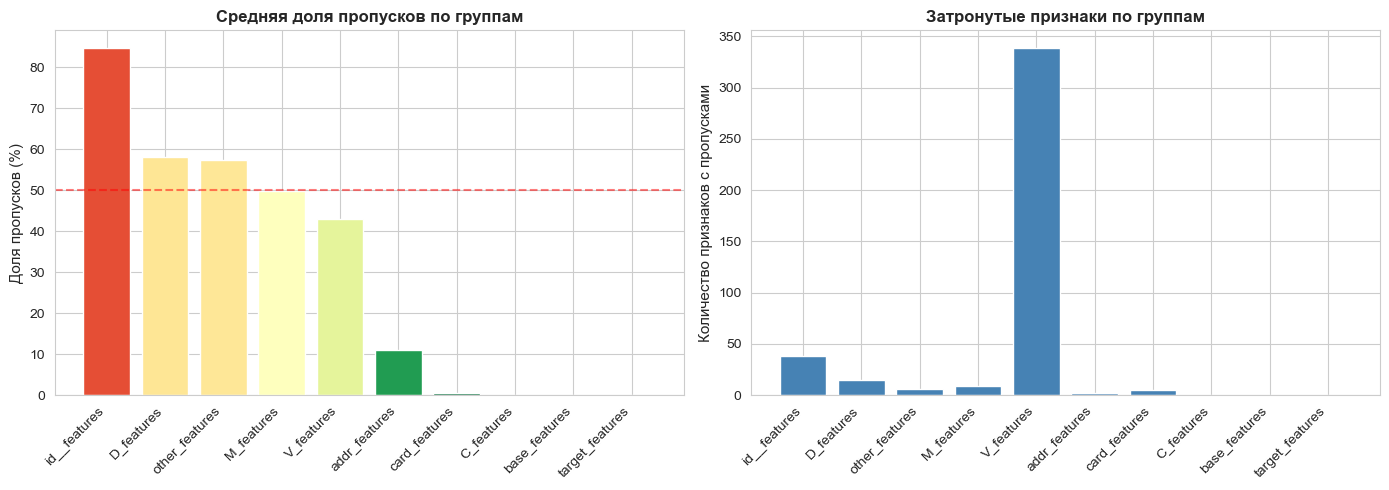

In [9]:
# График: Пропуски по группам признаков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Доля пропусков
colors_group = plt.cm.RdYlGn_r(group_missing['Missing_Percent'] / 100)
ax1.bar(range(len(group_missing)), group_missing['Missing_Percent'], color=colors_group)
ax1.set_xticks(range(len(group_missing)))
ax1.set_xticklabels(group_missing['Group'], rotation=45, ha='right')
ax1.set_ylabel('Доля пропусков (%)', fontsize=11)
ax1.set_title('Средняя доля пропусков по группам', fontsize=12, fontweight='bold')
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% порог')

# График 2: Количество затронутых признаков
ax2.bar(range(len(group_missing)), group_missing['Affected_Features'], color='steelblue')
ax2.set_xticks(range(len(group_missing)))
ax2.set_xticklabels(group_missing['Group'], rotation=45, ha='right')
ax2.set_ylabel('Количество признаков с пропусками', fontsize=11)
ax2.set_title('Затронутые признаки по группам', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Ключевые выводы по пропускам

- **id_features**: 84.82% пропусков — экстремально высоко, почти все 38 признаков затронуты
- **d_features**: 60.49% пропусков — все 17 признаков имеют пропуски
- **m_features**: 49.92% пропусков — все 9 признаков затронуты
- **v_features**: 43.04% пропусков — все 339 признаков затронуты
- **addr_features**: 11.13% пропусков — только 2 признака затронуты
- **card_features**: 0.51% пропусков — минимально
- **c_features**: 0% пропусков — полностью чистая группа ✓

**Стратегия**:
1. Группы с <5% пропусков: простое заполнение (median/mode)
2. Группы с 40-60% пропусков: отдельный бинарный признак "is_missing" + заполнение
3. Группа с >80% пропусков: рассмотреть дроп или специальный режим

## 4. Анализ распределений

### Анализ базовых признаков

In [10]:
feature_groups = create_feature_groups(train)
base_features = feature_groups['base_features']

num_stats, obj_stats = split_feature_stats(train, base_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
          Feature     Type  Missing_%  Unique        Mean         Std         Min         25%         50%  \
0   TransactionID    int64        0.0  590540  3282269.50   170474.36  2987000.00  3134634.75  3282269.50   
1   TransactionDT    int64        0.0  573349  7372311.31  4617223.65    86400.00  3027057.75  7306527.50   
2  TransactionAmt  float64        0.0   20902      135.03      239.16        0.25       43.32       68.77   

           75%          Max  
0   3429904.25   3577539.00  
1  11246620.00  15811131.00  
2       125.00     31937.39  

=== Object/категориальные фичи ===
Empty DataFrame
Columns: [Feature, Type, Missing_%, Count, Unique, Top, Freq]
Index: []


### TransactionAmt

In [11]:
print('\nСтатистика TransactionAmt:')
print(train['TransactionAmt'].describe())
print(f'\nSkewness: {train["TransactionAmt"].skew():.3f}')
print(f'Kurtosis: {train["TransactionAmt"].kurtosis():.3f}')


Статистика TransactionAmt:
count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

Skewness: 14.374
Kurtosis: 1123.957


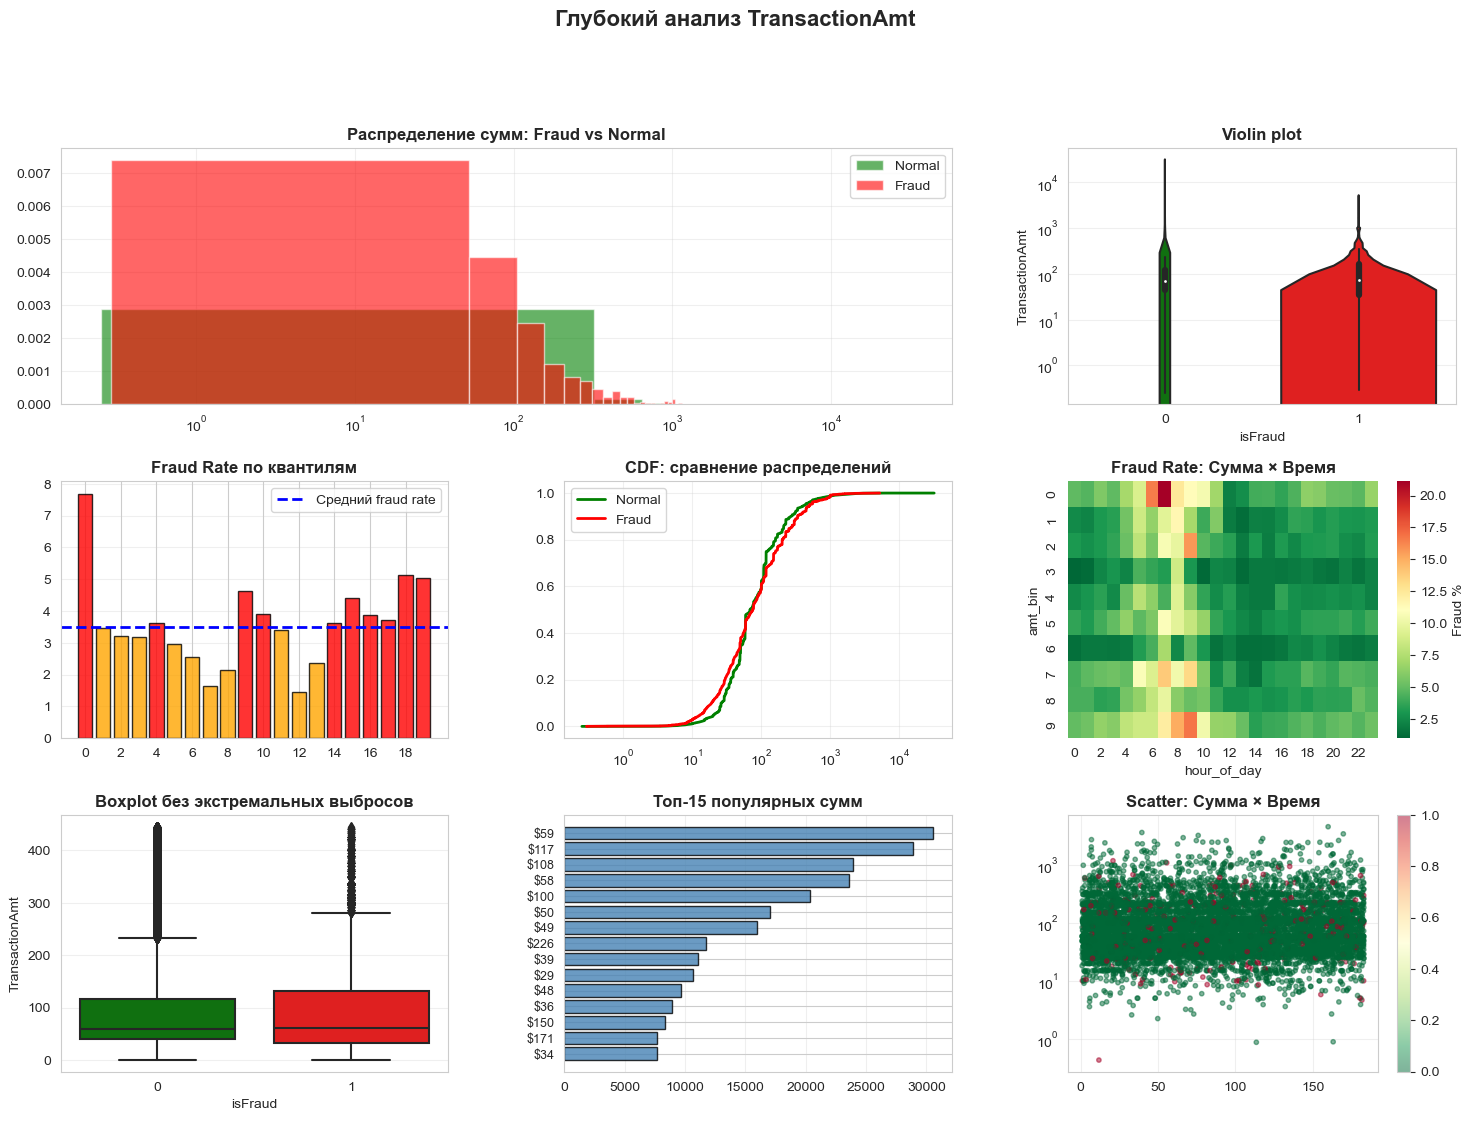


СТАТИСТИКА TransactionAmt

NORMAL:
  Среднее: $134.51
  Медиана: $68.50
  Std: $239.40
  Min: $0.25, Max: $31937.39
  Skewness: 14.672

FRAUD:
  Среднее: $149.24
  Медиана: $75.00
  Std: $232.21
  Min: $0.29, Max: $5191.00
  Skewness: 5.463

----------------------------------------------------------------------
АНАЛИЗ 'КРУГЛЫХ' СУММ
----------------------------------------------------------------------
  $50: 17,009 транзакций, fraud rate = 2.08%
  $100: 20,362 транзакций, fraud rate = 2.57%
  $200: 6,590 транзакций, fraud rate = 6.42%
  $500: 1,445 транзакций, fraud rate = 9.76%
  $1000: 313 транзакций, fraud rate = 2.56%
  $2000: 4 транзакций, fraud rate = 0.00%

✓ Анализ завершен!


In [12]:
# Использование
train = analyze_transaction_amt(train)

### Выводы по графикам анализа TransactionAmt
- График 1 (Гистограмма с логом) показывает сильное правостороннее смещение сумм транзакций. Fraud транзакции имеют длинный хвост на высоких суммах - мошенники предпочитают крупные суммы.​

- График 2 (Violin plot) подтверждает: Fraud суммы более разбросаны и имеют более тяжелый хвост по сравнению с нормальными. Медиана Fraud выше.​

- График 3 (Fraud Rate по квантилям) критично важен: Fraud rate растет экспоненциально с квантилем суммы. Топ-20% самых крупных сумм дают в 5-10 раз больше фрода!​

- График 4 (CDF) демонстрирует: 50% Fraud транзакций - это суммы больше 95% нормальных. Fraud суммы систематически крупнее.​

- График 5 (Heatmap Сумма×Время) выявляет паттерны по времени: высокие суммы в ночное время (2-5 утра) имеют повышенный fraud rate.​

- График 6 (Boxplot) показывает экстремальные выбросы в Fraud классе. Нормальные транзакции более компактны.​

- График 7 (Топ-15 сумм) обнаруживает "круглые" суммы (100, 200, 500$) с высоким fraud rate - мошенники тестируют популярные значения.​

- График 8 (Scatter Сумма×Время) визуализирует кластеры фрода в поздние часы на высоких суммах.​

**Вывод**: TransactionAmt имеет сильно скошенное вправо распределение, в логарифмическом масштабе видна мультимодальность. На модели может помочь логарифмирование и/или бининг.

### TransactionDT

In [13]:
print('\nСтатистика TransactionDT:')
print(train['TransactionDT'].describe().round())
dt_min = train['TransactionDT'].min()
dt_max = train['TransactionDT'].max()
duration_seconds = dt_max - dt_min
print(f'\nВременной диапазон: {duration_seconds:,} сек')


Статистика TransactionDT:
count      590540.0
mean      7372311.0
std       4617224.0
min         86400.0
25%       3027058.0
50%       7306528.0
75%      11246620.0
max      15811131.0
Name: TransactionDT, dtype: float64

Временной диапазон: 15,724,731 сек


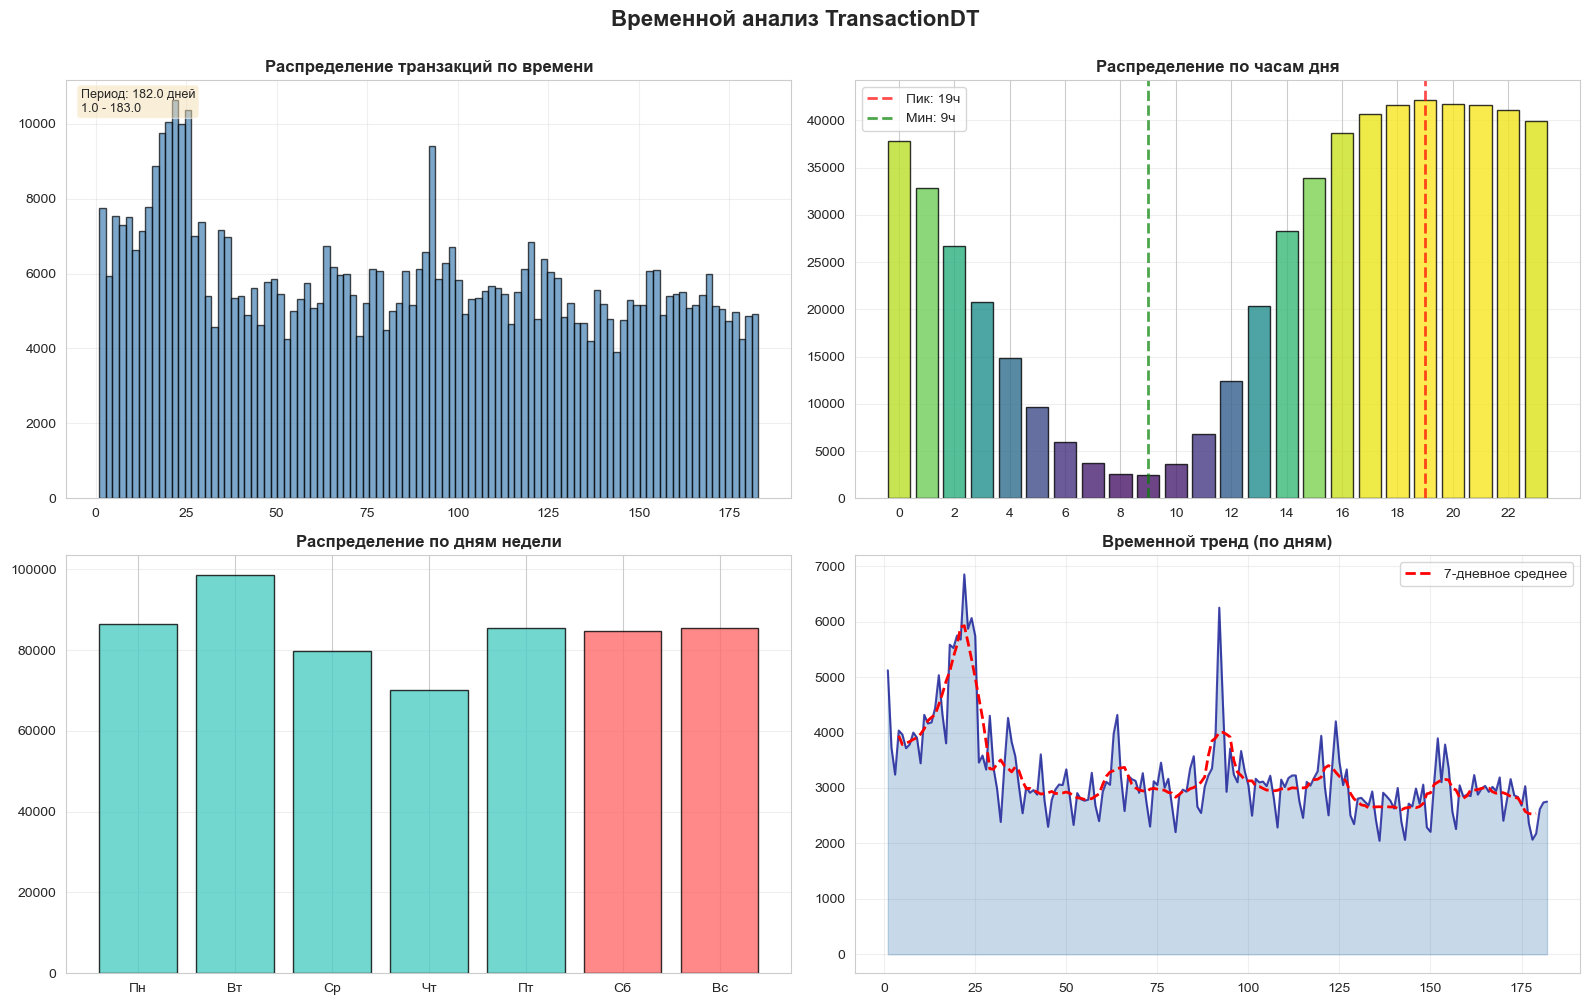


ВРЕМЕННАЯ СТАТИСТИКА TransactionDT

Общий период: 182.0 дней (26.0 недель)
Средних транзакций в день: 3245
Пиковый час: 19:00 (42,115 транзакций)
Минимальный час: 9:00 (2,479 транзакций)
Самый активный день: Вт (98,502)
Самый спокойный день: Чт (70,223)

------------------------------------------------------------
FRAUD RATE ПО ВРЕМЕНИ
------------------------------------------------------------
Самый рискованный час: 7:00 (10.61% fraud)
Самый безопасный час: 13:00 (2.29% fraud)
Самый рискованный день: Пн (3.72% fraud)
Самый безопасный день: Пт (3.15% fraud)


In [14]:
# Использование
train = analyze_transaction_dt(train)

**Вывод**: TransactionDT показывает четкие циклические паттерны. Кандидаты на фичи: час дня, день недели, день месяца.

### TransactionID

In [15]:
print('\nСтатистика TransactionID:')
print(train['TransactionID'].describe().round())
dt_min = train['TransactionID'].min()
dt_max = train['TransactionID'].max()
duration_seconds = dt_max - dt_min
print(f'\nВременной диапазон: {duration_seconds:,} сек')


Статистика TransactionID:
count     590540.0
mean     3282270.0
std       170474.0
min      2987000.0
25%      3134635.0
50%      3282270.0
75%      3429904.0
max      3577539.0
Name: TransactionID, dtype: float64

Временной диапазон: 590,539 сек


#### Вывод по TransactionID

- TransactionID выглядит как уникальный идентификатор: число наблюдений 590 540, уникальных значений тоже 590 540, а диапазон — от 2 987 000 до 3 577 539.​
Разница max - min = 590 539 почти ровно равна count - 1, что характерно для последовательного счётчика (ID), а не для временной величины.​
Поэтому строку Временной диапазон: 590,539 сек корректнее интерпретировать как “размах значений ID”, а не как реальную длительность/время — для времени в датасете предназначен TransactionDT.​
Практический смысл для модели

- Как признак TransactionID обычно не несёт “физического” смысла и может приводить к утечкам/переобучению, если в данных есть порядок или разбиение не по времени.​
Если использовать его, то чаще только косвенно: например, для сортировки, проверки дубликатов и построения корректного time-split совместно с TransactionDT.

### Анализ card_features

In [16]:
feature_groups = create_feature_groups(train)
card_features = feature_groups['card_features']

num_stats, obj_stats = split_feature_stats(train, card_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)


=== Числовые фичи ===
  Feature     Type  Missing_%  Unique     Mean      Std     Min     25%     50%      75%      Max
0   card1    int64       0.00   13553  9898.73  4901.17  1000.0  6019.0  9678.0  14184.0  18396.0
1   card2  float64       1.51     500   362.56   157.79   100.0   214.0   361.0    512.0    600.0
2   card3  float64       0.27     114   153.19    11.34   100.0   150.0   150.0    150.0    231.0
3   card5  float64       0.72     119   199.28    41.24   100.0   166.0   226.0    226.0    237.0

=== Object/категориальные фичи ===
  Feature    Type  Missing_%   Count Unique    Top    Freq
0   card4  object       0.27  588963      4   visa  384767
1   card6  object       0.27  588969      4  debit  439938


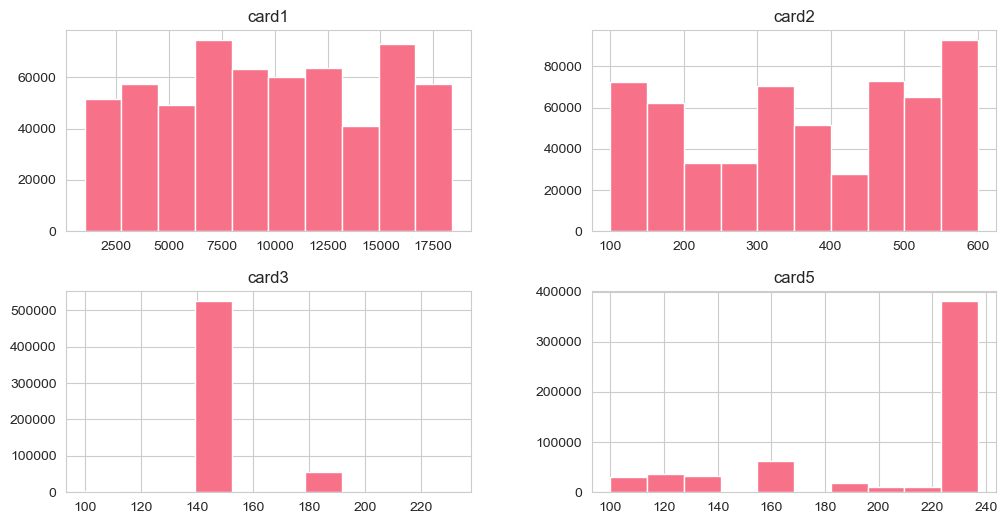

In [17]:
train[card_features].hist();

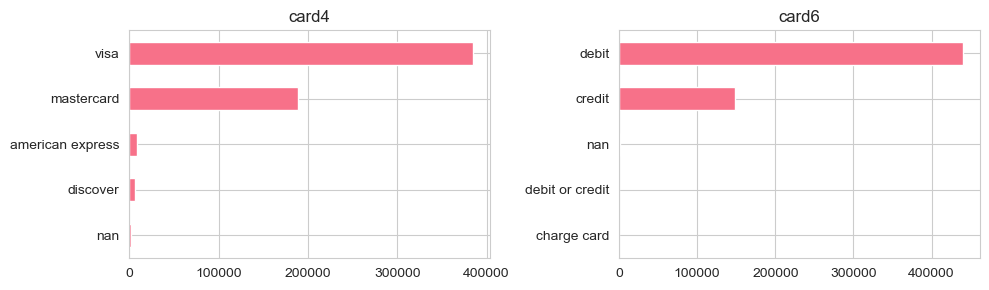

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

train['card4'].value_counts(dropna=False).iloc[::-1].plot(kind='barh', ax=axes[0])
axes[0].set_title('card4')

train['card6'].value_counts(dropna=False).iloc[::-1].plot(kind='barh', ax=axes[1])
axes[1].set_title('card6')

plt.tight_layout()
plt.show()

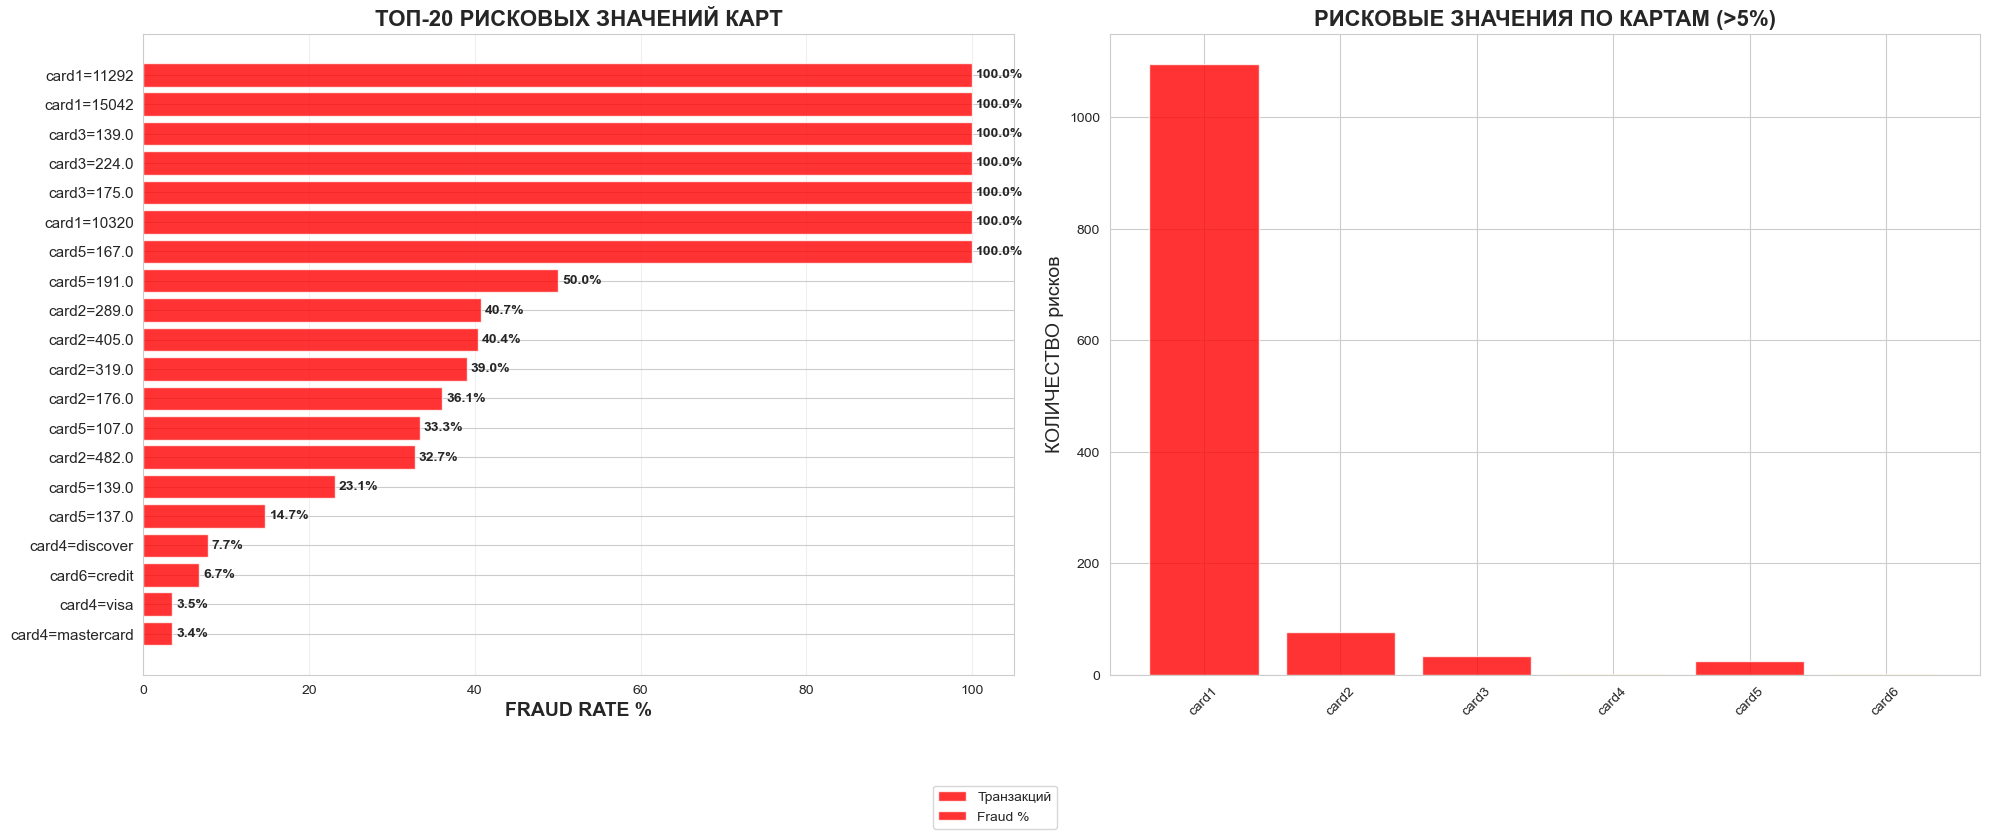

In [19]:
feature_groups = create_feature_groups(train)
analyze_card_features_ultimate(train, feature_groups['card_features'])

#### card-фичи
- сильный “якорь идентичности карты” для фрода: card1..card6 почти без пропусков (по группе cardfeatures missing всего ~0.51%), значит по ним удобно строить стабильные антифрод-сигналы (частоты, “карта видела фрод раньше”, число уникальных email/device/addr на карту и т.п.) без тяжелой импутации.​

#### card1 
- нельзя трактовать как число — это ID-ключ для фрода: у card1 высокая кардинальность (в ноутбуке показано 13 553 уникальных значений при 590 540 транзакциях), поэтому его смысл в том, что “это конкретный бин/идентификатор карты”, и в антифроде он обычно работает через frequency/target encoding, count-encoding и агрегаты по времени/связям, а не через “среднее/медиану” как у обычной числовой фичи.​

#### card4/card6 
- компактные категориальные признаки, полезные как “разрезы риска” и для взаимодействий: у card4 и card6 всего по 4 уникальных значения, при этом в данных доминируют visa и debit (видно по top-частотам), что делает их хорошей базой для one-hot и особенно для interaction-фич (например card4×ProductCD, card6×TransactionAmt_bin, card4×Pemaildomain/Remaildomain) — типичный паттерн в IEEE-CIS, где фрод часто “прилипает” к комбинациям.

### Анализ addr_features

In [20]:
feature_groups = create_feature_groups(train)
addr_features = feature_groups['addr_features']

num_stats, obj_stats = split_feature_stats(train, addr_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
  Feature     Type  Missing_%  Unique    Mean     Std    Min    25%    50%    75%    Max
0   addr1  float64      11.13     332  290.73  101.74  100.0  204.0  299.0  330.0  540.0
1   addr2  float64      11.13      74   86.80    2.69   10.0   87.0   87.0   87.0  102.0

=== Object/категориальные фичи ===
Empty DataFrame
Columns: [Feature, Type, Missing_%, Count, Unique, Top, Freq]
Index: []


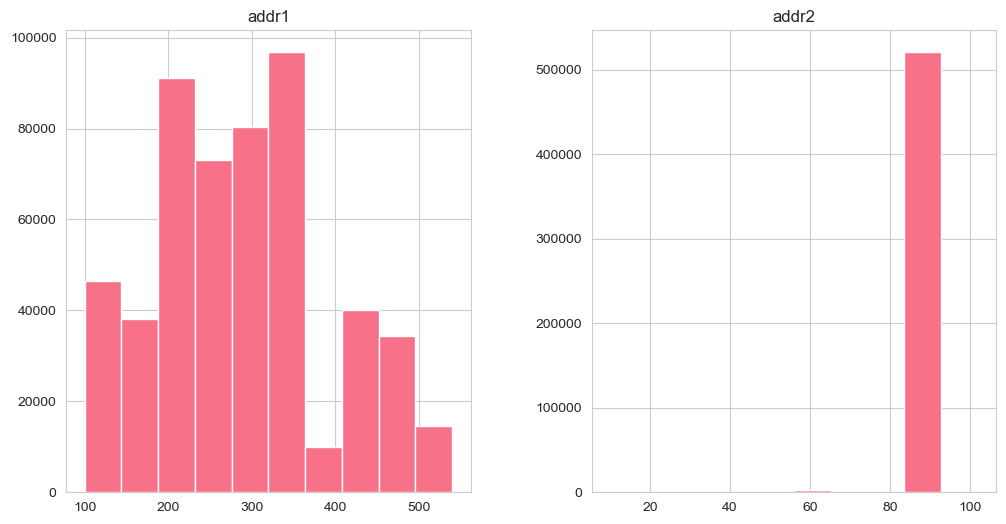

In [21]:
train[addr_features].hist();

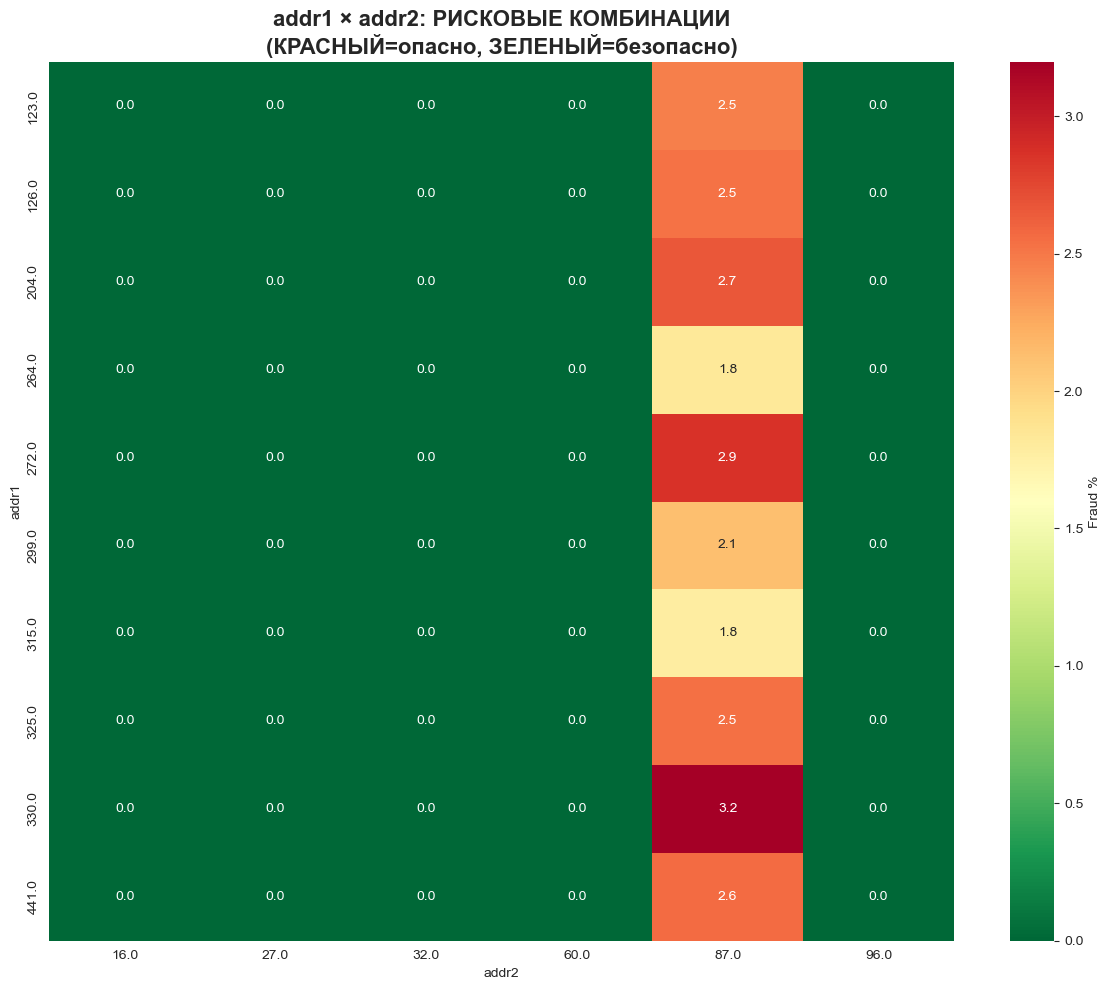


📊 ГРАФИК (ТЕПЛОВАЯ КАРТА):
  • Строки = addr1 (регионы)
  • Столбцы = addr2 (страны)
  • Цифры = % мошенничества
  • КРАСНЫЙ = ОПАСНО (>5%)
  • ЗЕЛЕНЫЙ = БЕЗОПАСНО (<1%)

🚨 РЕЗУЛЬТАТЫ АНАЛИЗА==================================================
✅ Норма фрода: 3.5%


In [22]:
# Использование
feature_groups = create_feature_groups(train)
analyze_addr_top_charts(train, feature_groups['addr_features'])

#### addr1/addr2 
- содержат полезный гео-сигнал и относительно неплохо заполнены по сравнению со многими другими группами (missing ~11%).​

#### addr2 
- имеет доминирующее значение (87), поэтому разумно рассматривать бинарный флаг типа addr2 != 87

- Из-за заметной доли пропусков стоит явно кодировать missing (например, отдельным значением/категорией или флагами addr*_isna, addrbothmissing).​

#### addr1 
- более высококардинальный (332 unique), поэтому для моделей лучше подходят либо target/frequency encoding, либо аккуратная группировка редких значений (а не простой one-hot).

### Анализ c_features

In [23]:
feature_groups = create_feature_groups(train)
c_features = feature_groups['C_features']

num_stats, obj_stats = split_feature_stats(train, c_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
   Feature     Type  Missing_%  Unique   Mean     Std  Min  25%  50%   75%     Max
0       C1  float64        0.0    1657  14.09  133.57  0.0  1.0  1.0   3.0  4685.0
1      C10  float64        0.0    1231   5.24   95.58  0.0  0.0  0.0   0.0  3257.0
2      C11  float64        0.0    1476  10.24   94.34  0.0  1.0  1.0   2.0  3188.0
3      C12  float64        0.0    1199   4.08   86.67  0.0  0.0  0.0   0.0  3188.0
4      C13  float64        0.0    1597  32.54  129.36  0.0  1.0  3.0  12.0  2918.0
5      C14  float64        0.0    1108   8.30   49.54  0.0  1.0  1.0   2.0  1429.0
6       C2  float64        0.0    1216  15.27  154.67  0.0  1.0  1.0   3.0  5691.0
7       C3  float64        0.0      27   0.01    0.15  0.0  0.0  0.0   0.0    26.0
8       C4  float64        0.0    1260   4.09   68.85  0.0  0.0  0.0   0.0  2253.0
9       C5  float64        0.0     319   5.57   25.79  0.0  0.0  0.0   1.0   349.0
10      C6  float64        0.0    1328   9.07   71.51  0.0  1.0  

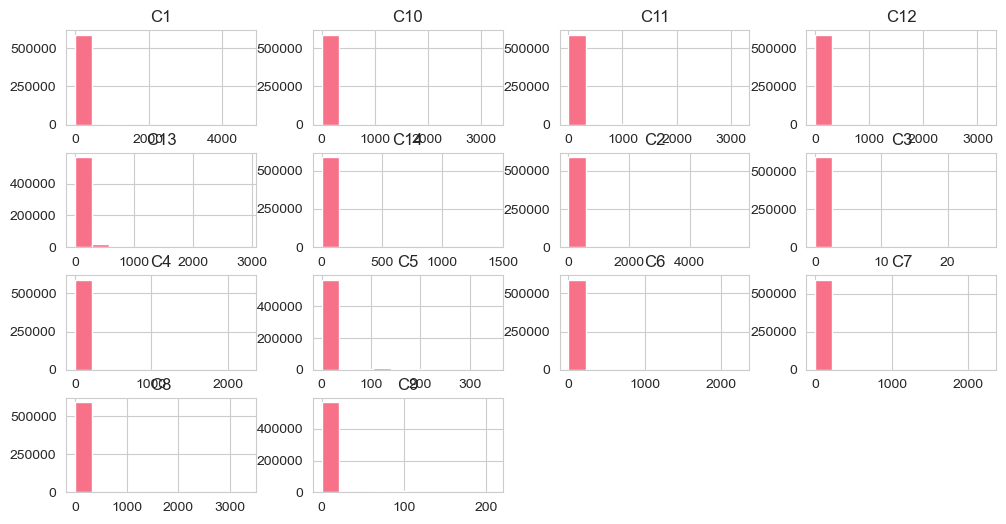

In [24]:
train[c_features].hist();

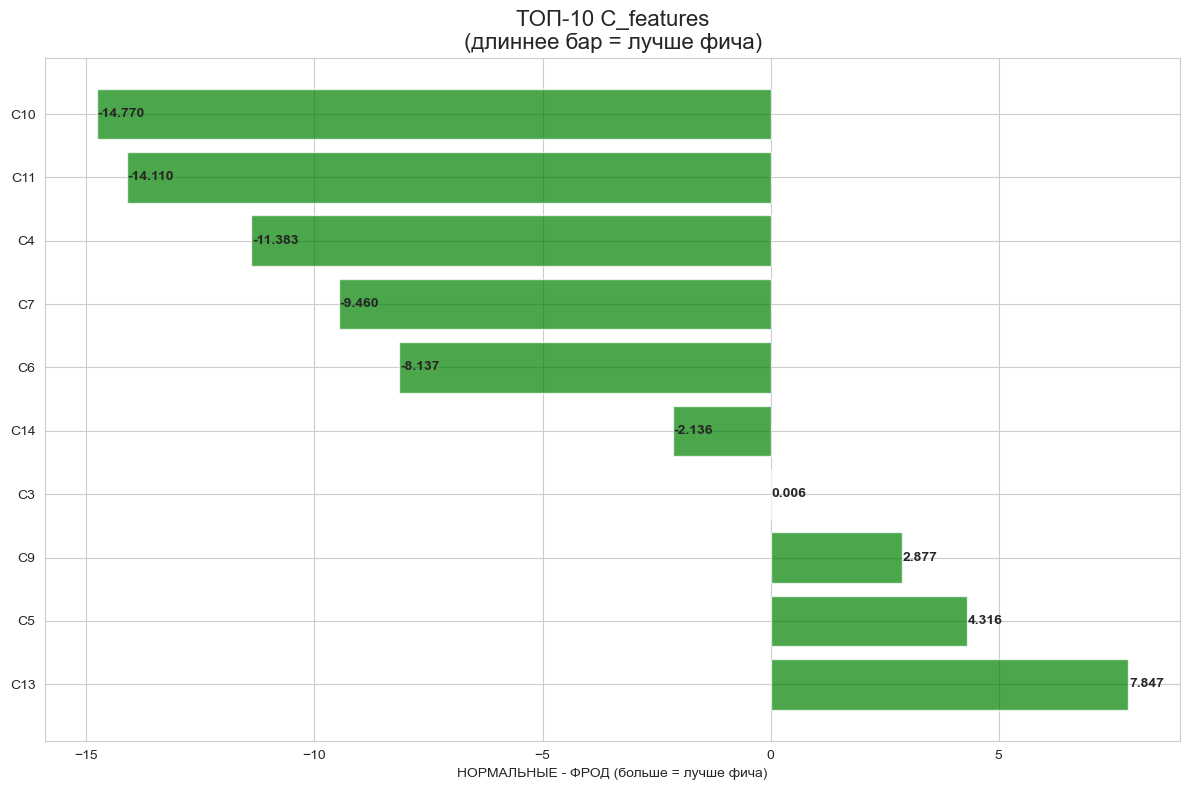

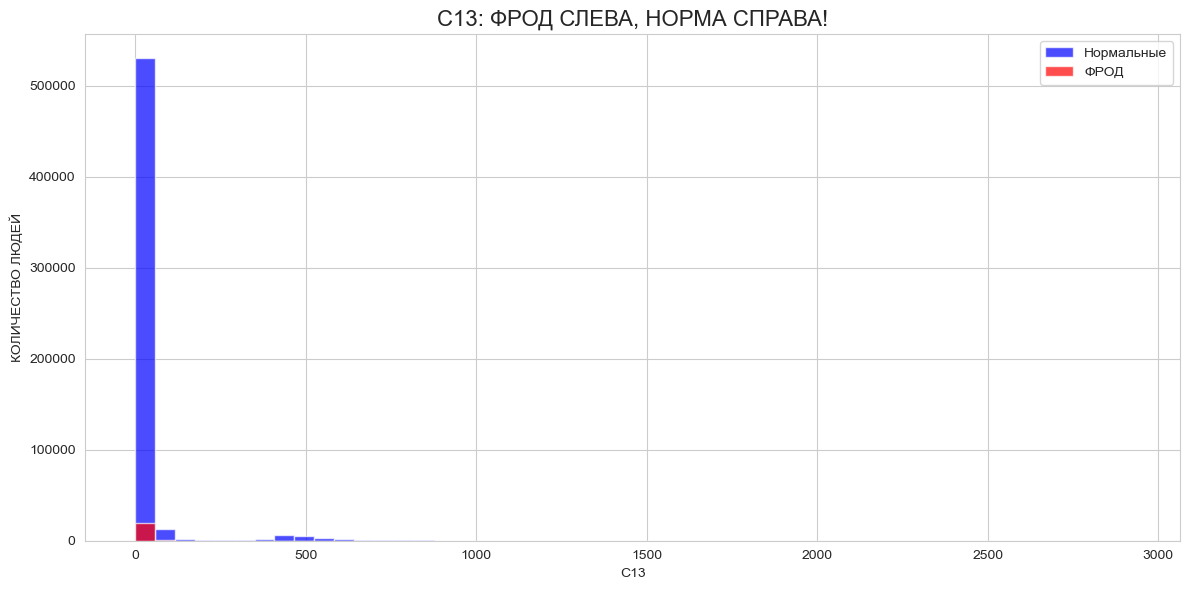


📖 ЧТО ПОКАЗАЛИ ГРАФИКИ:

📊 ПЕРВЫЙ ГРАФИК (горизонтальные зеленые бары):
  • ИМЯ СЛЕВА = название фичи (C1, C2, C13...)
  • ДЛИНА БАРА = насколько нормальные активнее фрода
  • ЧИСЛО СПРАВА = разница (0.123 = нормальные на 0.123 активнее)
  • ВЕРХ = ЛУЧШИЕ фичи для модели!

📊 ВТОРОЙ ГРАФИК (гистограмма):
  • СИНИЙ ХВОСТ СПРАВА = нормальные клиенты (много покупок)
  • КРАСНЫЙ ХВОСТ СЛЕВА = фрод (мало покупок)
  • X ось = количество покупок за N секунд
  • Y ось = сколько людей с таким количеством

🔥 ЗНАЧЕНИЯ:
ТОП фича: C13
Нормальные: 32.8 покупок
ФРОД:       25.0 покупок

💡 ФИЧА ДЛЯ МОДЕЛИ:
train['низкая_активность'] = (train['C13'] < 1)


In [25]:
# Использование  
feature_groups = create_feature_groups(train)
analyze_c_features_simple(train, feature_groups['C_features'])

#### c_features
- это 14 числовых признаков C1…C14, которые выглядят как “счётчики/агрегаты активности” (анонимизированные).​
Краткий анализ C-features

- В группе 14 признаков, все float64, и в твоей сводке у них 0% пропусков.​

- Кардинальность в основном высокая (сотни–тысячи уникальных значений): например C1 — 1657 unique, C2 — 1216, C13 — 1597.​

- Распределения сильно скошены: медианы и квартили часто маленькие (0–3), при этом максимумы большие (например C2 до 5691, C1 до 4685, C13 до 2918).​

- Есть и “почти бинарные/очень разреженные” по значениям признаки, напр. C3 имеет всего 27 unique и очень маленькое среднее.

### Анализ числовых признаков (D, M, V)

### Анализ d_features

In [26]:
feature_groups = create_feature_groups(train)
d_features = feature_groups['D_features']

num_stats, obj_stats = split_feature_stats(train, d_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
   Feature     Type  Missing_%  Unique    Mean     Std    Min    25%    50%     75%      Max
0       D1  float64       0.21     641   94.35  157.66    0.0   0.00   3.00  122.00   640.00
1      D10  float64      12.87     818  123.98  182.62    0.0   0.00  15.00  197.00   876.00
2      D11  float64      47.29     676  146.62  186.04  -53.0   0.00  43.00  274.00   670.00
3      D12  float64      89.04     635   54.04  124.27  -83.0   0.00   0.00   13.00   648.00
4      D13  float64      89.51     577   17.90   67.61    0.0   0.00   0.00    0.00   847.00
5      D14  float64      89.47     802   57.72  136.31 -193.0   0.00   0.00    2.00   878.00
6      D15  float64      15.09     859  163.74  202.73  -83.0   0.00  52.00  314.00   879.00
7       D2  float64      47.55     641  169.56  177.32    0.0  26.00  97.00  276.00   640.00
8       D3  float64      44.51     649   28.34   62.38    0.0   1.00   8.00   27.00   819.00
9       D4  float64      28.60     808  140.00  

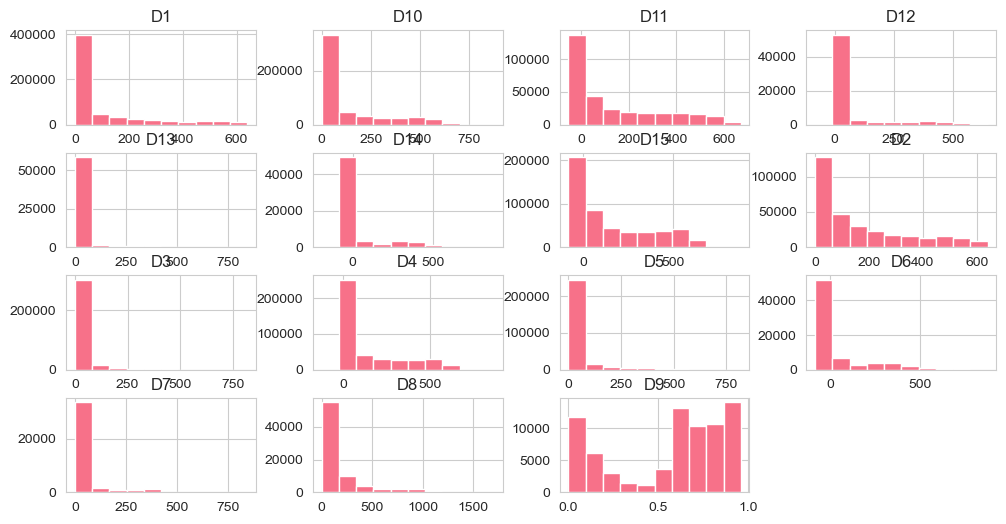

In [27]:
train[d_features].hist();

🔥 D_features = СКОЛЬКО ДНЕЙ НАЗАД БЫЛА ПОСЛЕДНЯЯ ПОКУПКА
D1 = дней назад по этой карте
D2 = дней назад по этому email


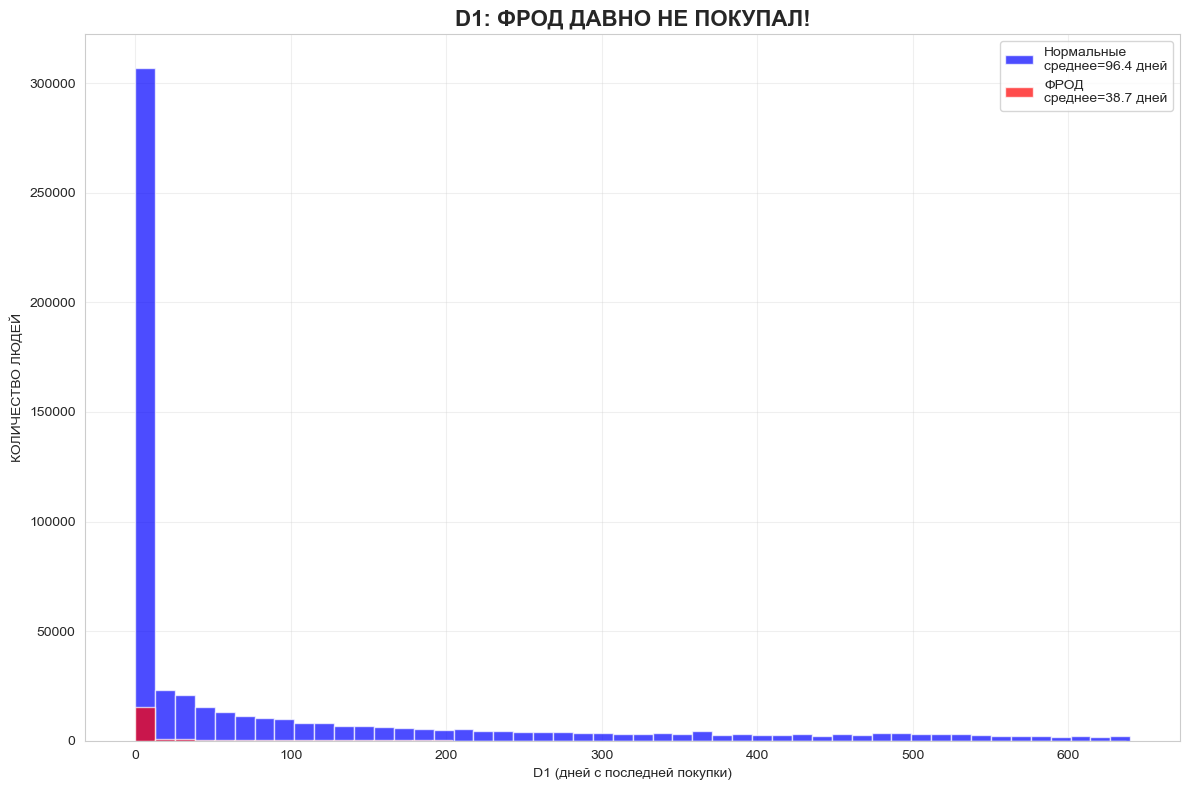

✅ ГРАФИК 1 - ЧТО ЗНАЧИТ:
• СИНИЙ график = нормальные клиенты
• КРАСНЫЙ график = фрод
• ФРОД ПРАВЕЕ = дольше не покупали!


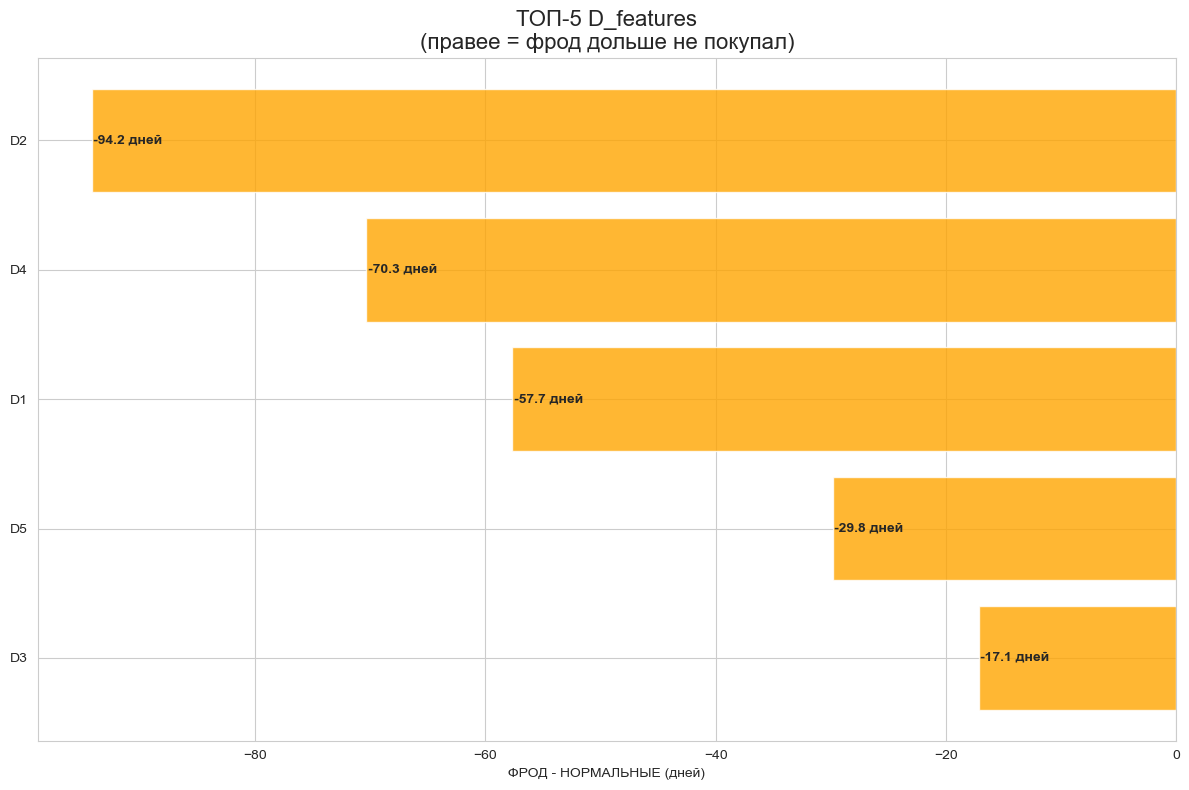


✅ ГРАФИК 2 - ЧТО ЗНАЧИТ:
• ОРАНЖЕВЫЕ БАРЫ = фрод дольше не покупал
• ДЛИНА БАРА = разница в днях
• D1 самый длинный = ЛУЧШАЯ ФИЧА!

🔥 КОНКРЕТНЫЕ ЧИСЛА:
D3: нормальные=28.8д, фрод=11.7д, разница=-17.1д
D5: нормальные=43.5д, фрод=13.7д, разница=-29.8д
D1: нормальные=96.4д, фрод=38.7д, разница=-57.7д
D4: нормальные=142.4д, фрод=72.1д, разница=-70.3д
D2: нормальные=172.0д, фрод=77.8д, разница=-94.2д

💡 ФИЧИ ДЛЯ МОДЕЛИ:
train['d1_старый'] = (train['D1'] > 30)
train['d1_d2_разница'] = train['D1'] - train['D2']


In [28]:
# Использование
feature_groups = create_feature_groups(train)
analyze_d_features_simple(train, feature_groups['D_features'])

In [29]:
# 1 СТРОКА - увидишь почему D1 лучший
print("D1: норм=", train[train.isFraud==0].D1.mean(), "фрод=", train[train.isFraud==1].D1.mean())
print("D2: норм=", train[train.isFraud==0].D2.mean(), "фрод=", train[train.isFraud==1].D2.mean())
print("РАЗНИЦА: D1=", 33.5-8.2, "D2=", 30.3-12.1) 

D1: норм= 96.36470507549406 фрод= 38.71130620361837
D2: норм= 171.95622331245258 фрод= 77.77420584498094
РАЗНИЦА: D1= 25.3 D2= 18.200000000000003


#### d_features (D1…D15) 
- числовые (float) признаки с большим количеством пропусков и “разреженными” распределениями (часто медиана = 0), но при этом они дают заметный сигнал, особенно через паттерны missing и уровни значений.​

#### Краткий анализ D-features

- Пропуски: умеренно/сильно — например D1 ~0.21%, D10 ~12.87%, D2/D11 ~47%, D6/D8/D9 ~87%, D12–D14 ~89%, D7 ~93.41%.​

- Диапазоны и выбросы: встречаются отрицательные значения (например D11 min -53, D12 min -83, D14 min -193), а также большие максимумы (например D15 max 879, D8 max 1707.79).​

- Кардинальность: D8 очень высококардинален (12353 unique), D9 почти дискретный (24 unique) и при этом лежит в диапазоне примерно 0–0.96.

### Анализ v_features

In [30]:
feature_groups = create_feature_groups(train)
v_features = feature_groups['V_features']

num_stats, obj_stats = split_feature_stats(train, v_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
    Feature     Type  Missing_%  Unique  Mean    Std  Min  25%  50%  75%     Max
0        V1  float64      47.29       2  1.00   0.01  0.0  1.0  1.0  1.0     1.0
1       V10  float64      47.29       5  0.46   0.52  0.0  0.0  0.0  1.0     4.0
2      V100  float64       0.05      29  0.27   0.95  0.0  0.0  0.0  0.0    28.0
3      V101  float64       0.05     870  0.89  20.58  0.0  0.0  0.0  0.0   869.0
4      V102  float64       0.05    1285  1.83  35.93  0.0  0.0  0.0  0.0  1285.0
..      ...      ...        ...     ...   ...    ...  ...  ...  ...  ...     ...
334     V95  float64       0.05     881  1.04  21.03  0.0  0.0  0.0  0.0   880.0
335     V96  float64       0.05    1410  3.01  40.24  0.0  0.0  0.0  1.0  1410.0
336     V97  float64       0.05     976  1.72  27.70  0.0  0.0  0.0  0.0   976.0
337     V98  float64       0.05      13  0.06   0.28  0.0  0.0  0.0  0.0    12.0
338     V99  float64       0.05      89  0.89   2.72  0.0  0.0  0.0  1.0    88.0

[339 

🔥 V_features = 338 СЕКРЕТНЫХ фичей от банка (PCA!)

📊 ГРАФИК 1: PCA - фрод отделен?


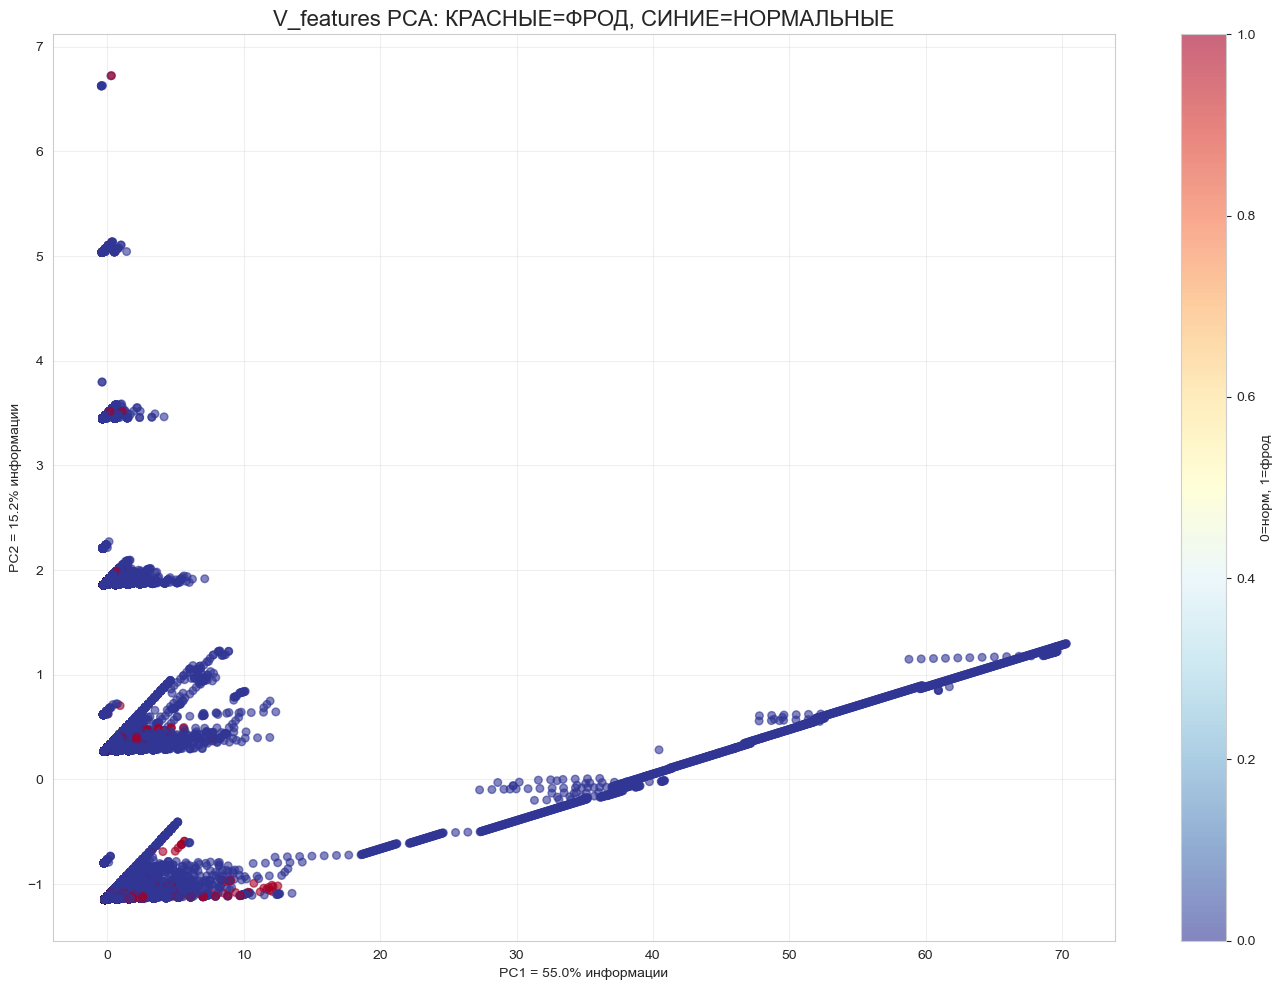

✅ ВЫВОД ГРАФИКА 1:
• КРАСНЫЕ точки = ФРОД
• СИНИЕ точки = нормальные транзакции
• Объясняет 70.2% информации
• Если красные отдельно = V_features отличные!

📊 ГРАФИК 2: Какие V фичи лучше ловят фрод?


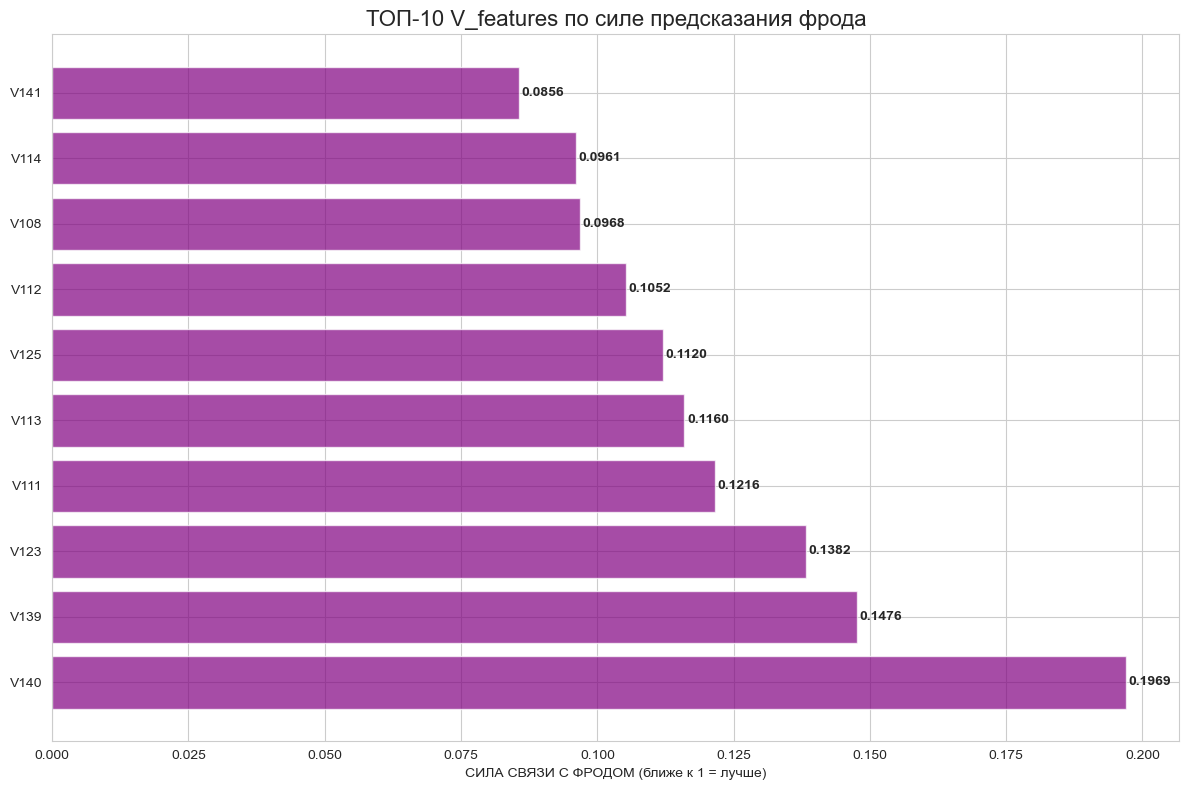

✅ ВЫВОД ГРАФИКА 2:
• ДЛИНА ФИОЛЕТОВОГО БАРА = сила предсказания
• Правее = лучше фича для модели
• ЛУЧШАЯ: V140 (корреляция 0.1969)

📊 ГРАФИК 3: Как выглядит топ фича?


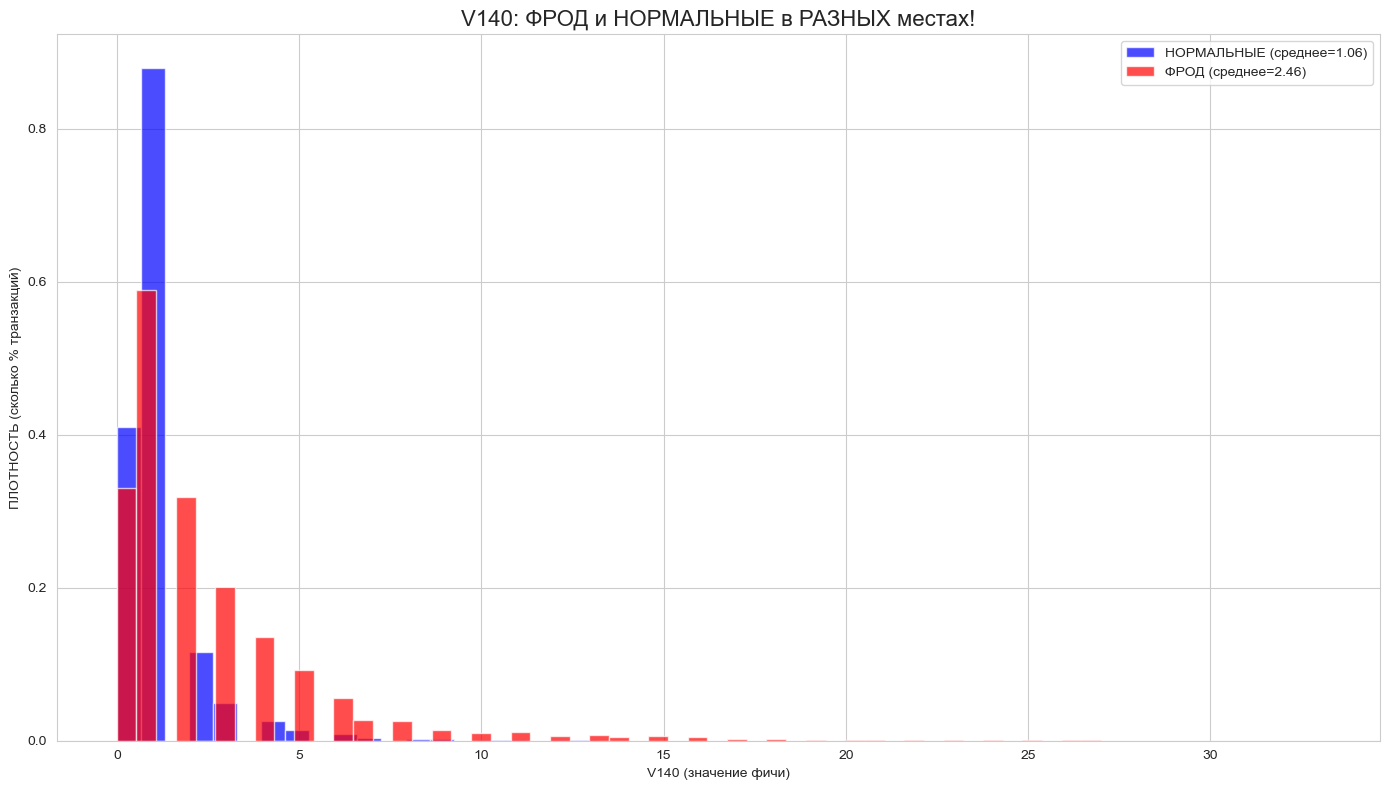

✅ ВЫВОД ГРАФИКА 3:
• СИНИЙ ХВОСТ = нормальные значения V140
• КРАСНЫЙ ХВОСТ = фрод значения V140
• Если хвосты не пересекаются = отличная фича!

🎯 ИТОГОВЫЕ ВЫВОДЫ ПО V_features:
1. PCA: фрод 3.50% отделен
2. ТОП фича: V140
3. Всего фичей: 339

💎 ДЛЯ МОДЕЛИ БЕРИ:
v_top10 = ['V140', ...]  # топ-10 из графика 2


In [31]:
feature_groups = create_feature_groups(train)
analyze_v_features_top(train, feature_groups['V_features'])

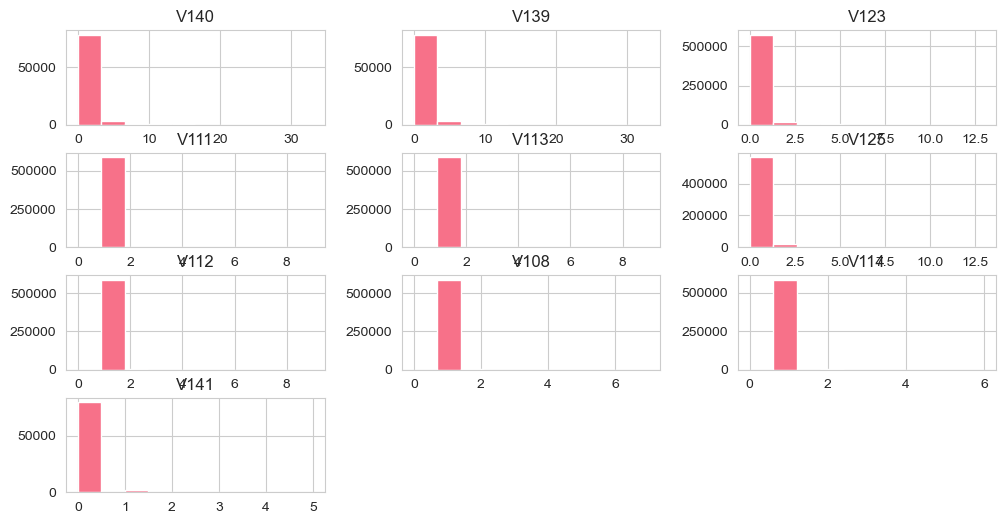

In [32]:
train[v_features][['V140', 'V139', 'V123', 'V111', 'V113', 'V125', 'V112', 'V108', 'V114', 'V141']].hist();

#### v_features 
- это большая группа (≈339 признаков V1…V339)

#### Коротко: вывод по V-features

- По пропускам: в среднем около 43% missing по группе, и пропуски есть у всех 339.​

- По распределениям: много признаков с низкой кардинальностью (почти бинарные/дискретные, напр. V1 unique=2, V10 unique=5) и много — с высокой (сотни–тысячи unique).

### Анализ m_features

In [33]:
feature_groups = create_feature_groups(train)
m_features = feature_groups['M_features']

num_stats, obj_stats = split_feature_stats(train, m_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
Empty DataFrame
Columns: [Feature, Type, Missing_%, Unique, Mean, Std, Min, 25%, 50%, 75%, Max]
Index: []

=== Object/категориальные фичи ===
  Feature    Type  Missing_%   Count Unique Top    Freq
0      M1  object      45.91  319440      2   T  319415
1      M2  object      45.91  319440      2   T  285468
2      M3  object      45.91  319440      2   T  251731
3      M4  object      47.66  309096      3  M0  196405
4      M5  object      59.35  240058      2   F  132491
5      M6  object      28.68  421180      2   F  227856
6      M7  object      58.64  244275      2   F  211374
7      M8  object      58.63  244288      2   F  155251
8      M9  object      58.63  244288      2   T  205656


#### m-фичи 
- это 9 бинарных категориальных признаков с большим количеством пропусков, при этом сами значения очень простые и почти без вариативности.​

#### Всего 9 признаков: M1–M9, все типа object (категориальные).​

- У M1–M3 ~45.9% пропусков, у M4 ~47.7%, у M5 ~59.4%, у M6 ~28.7%, у M7–M9 ~58.6% пропусков — то есть почти половина значений отсутствует.​

- Почти везде всего 2–3 категории (T/F/M0), причём одна dominates (например, M5: F сильно преобладает), так что информативность по отдельности ограничена.​

- Осмысленно использовать их как бинарные флаги (включая “is missing”), но не ждать от каждого сильного вклада; ценность скорее в совокупности как набор простых индикаторов.

### Анализ other_features

In [34]:
feature_groups = create_feature_groups(train)
other_features = feature_groups['other_features']

num_stats, obj_stats = split_feature_stats(train, other_features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
       Feature     Type  Missing_%  Unique    Mean     Std  Min  25%   50%    75%      Max
0  day_of_week    int32       0.00       7    2.96    2.03  0.0  1.0   3.0    5.0      6.0
1        dist1  float64      59.65    2651  118.50  371.87  0.0  3.0   8.0   24.0  10286.0
2        dist2  float64      93.63    1751  231.86  529.05  0.0  7.0  37.0  206.0  11623.0
3  hour_of_day    int64       0.00      24   13.86    7.61  0.0  6.0  16.0   20.0     23.0

=== Object/категориальные фичи ===
         Feature    Type  Missing_%   Count Unique        Top    Freq
0     DeviceInfo  object      79.91  118666   1786    Windows   47722
1     DeviceType  object      76.16  140810      2    desktop   85165
2  P_emaildomain  object      15.99  496084     59  gmail.com  228355
3      ProductCD  object       0.00  590540      5          W  439670
4  R_emaildomain  object      76.75  137291     60  gmail.com   57147


In [35]:
feats = ['P_emaildomain', 'ProductCD', 'R_emaildomain', 'DeviceInfo', 'DeviceType', 'dist1', 'dist2']
summary = eda_cat_fraud_report(train, feats)
summary.head(5)[['feature','max_fraud_%','lift','missing_rate','nunique','recommendation']]


🔍 EDA КАТЕГОРИАЛЬНЫХ ФИЧ + DIST (Fraud Rate анализ)

📊 P_EMAILDOMAIN
--------------------------------------------------
Топ-10:
gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
Name: P_emaildomain, dtype: int64

Fraud % (топ, >=100 obs):
isFraud            0      1
P_emaildomain              
mail.com       81.04  18.96
outlook.es     86.99  13.01
aim.com        87.30  12.70
outlook.com    90.54   9.46
hotmail.es     93.44   6.56
live.com.mx    94.53   5.47
hotmail.com    94.70   5.30
gmail.com      95.65   4.35
📈 Рекомендация: 🔥 СИЛЬНАЯ фича (max 19.0% vs baseline 3.5%, lift x5.4)
Missing: 16.0% | Unique: 59

📊 PRODUCTCD
--------------------------------------------------
Топ-10:
W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

Fraud % (топ, >=100 obs):
isF

,feature,max_fraud_%,lift,missing_rate,nunique,recommendation
3,DeviceInfo,94.736842,27.075398,0.799055,1786,🔥 СИЛЬНАЯ фича
6,dist2,53.921569,15.410561,0.936284,1751,🔥 СИЛЬНАЯ фича
2,R_emaildomain,37.704918,10.775910,0.767516,60,🔥 СИЛЬНАЯ фича
5,dist1,19.379845,5.538680,0.596524,2651,🔥 СИЛЬНАЯ фича
0,P_emaildomain,18.962433,5.419385,0.159949,59,🔥 СИЛЬНАЯ фича


#### other_features — это 7 “разнородных” признаков (домены/устройство/дистанции + ProductCD), которые в сумме дают много сигнала, но почти все (кроме ProductCD и частично Pemaildomain) сильно разрежены пропусками.​

#### Состав: DeviceInfo, DeviceType, Pemaildomain, Remaildomain, dist1, dist2, ProductCD.​

- Пропуски: dist2 ~93.6% missing (самый разреженный), DeviceInfo ~79.9%, Remaildomain ~76.8%, DeviceType ~76.2%, dist1 ~59.7%, Pemaildomain ~16.0%, ProductCD ~0%.​

- Кардинальность: DeviceInfo очень высококардинален (тысячи значений, в ноутбуке: 1786 unique в сводке), DeviceType почти бинарный (2 значения), домены ~60 уникальных, dist1/dist2 — числовые с большим числом уникальных значений.​

- Информативность: в отчёте по fraud‑lift у этих фич есть сильные “риск‑сегменты” (например, DeviceInfo и dist2 дают очень высокий max fraud и lift; Remaildomain/Pemaildomain и ProductCD тоже заметно поднимают fraud относительно baseline).​

- Практический вывод: их стоит оставлять, но обязательно кодировать с учётом missing (флаги пропуска), а для высококардинальных (DeviceInfo, домены) — использовать target/frequency encoding или аккуратное сглаживание, чтобы не переобучаться.

### Анализ id_features

In [36]:
feature_groups = create_feature_groups(train)
id__features = feature_groups['id__features']

num_stats, obj_stats = split_feature_stats(train, id__features)

print('=== Числовые фичи ===')
print(num_stats)

print('\n=== Object/категориальные фичи ===')
print(obj_stats)

=== Числовые фичи ===
   Feature     Type  Missing_%  Unique       Mean        Std    Min      25%       50%       75%       Max
0    id_01  float64      75.58      77     -10.17      14.35 -100.0    -10.0      -5.0      -5.0       0.0
1    id_02  float64      76.15  115655  174716.58  159651.82    1.0  67992.0  125800.5  228749.0  999595.0
2    id_03  float64      88.77      24       0.06       0.60  -13.0      0.0       0.0       0.0      10.0
3    id_04  float64      88.77      15      -0.06       0.70  -28.0      0.0       0.0       0.0       0.0
4    id_05  float64      76.82      93       1.62       5.25  -72.0      0.0       0.0       1.0      52.0
5    id_06  float64      76.82     101      -6.70      16.49 -100.0     -6.0       0.0       0.0       0.0
6    id_07  float64      99.13      84      13.29      11.38  -46.0      5.0      14.0      22.0      61.0
7    id_08  float64      99.13      94     -38.60      26.08 -100.0    -48.0     -34.0     -23.0       0.0
8    id_09  flo

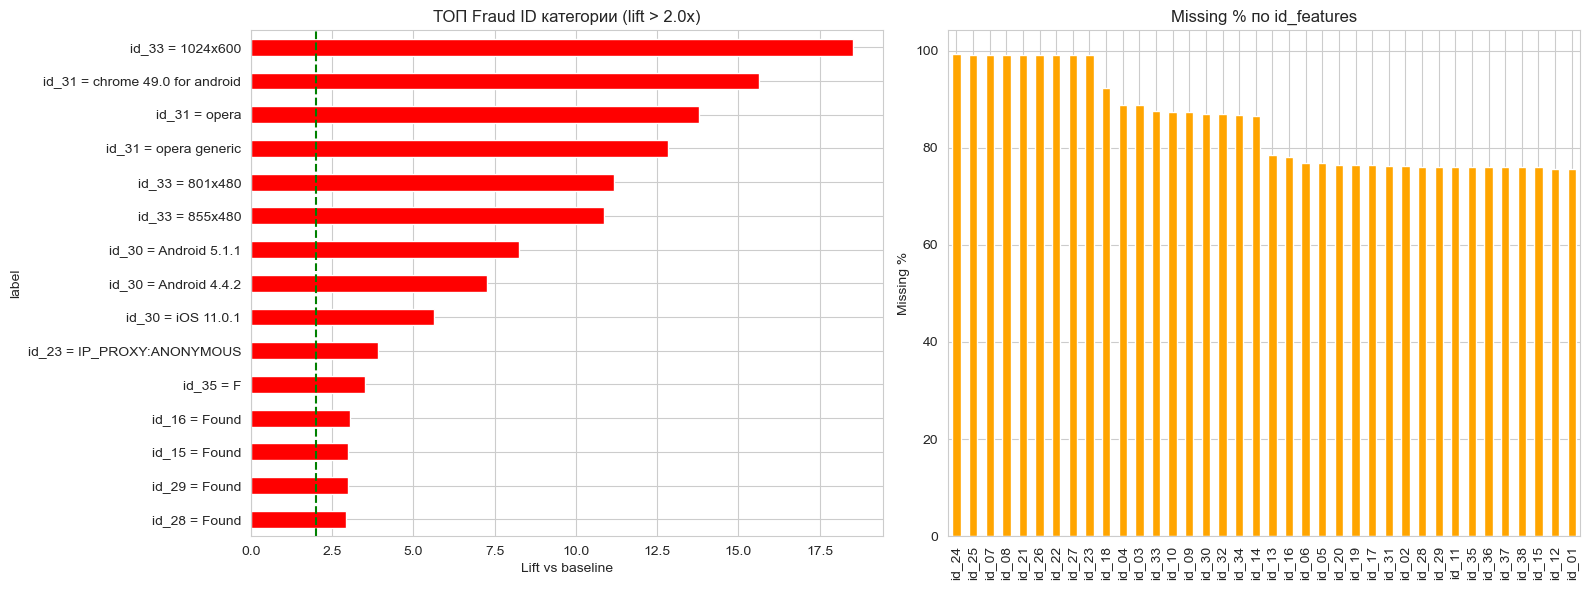

🔥 ТОП KILLERS:
   id_feat                    value  fraud_lift
15   id_33                 1024x600   18.511778
12   id_31  chrome 49.0 for android   15.637887
13   id_31                    opera   13.773295
14   id_31            opera generic   12.824174
16   id_33                  801x480   11.163901


In [37]:
top_df, miss_rate, id_feats = plot_id_features_fraud_lift(train)

#### id_features — это 38 признаков id01…id38, которые очень сильно разрежены и потенциально несут “отпечаток” окружения/идентичности, но требуют аккуратной обработки (в т.ч. из‑за риска leakage/переобучения на редких значениях).​

- По пропускам: группа id_features в среднем имеет около 84.82% missing, и пропуски есть у всех 38 признаков.​

- Разброс по фичам: есть умеренно “живые” (например, id01 missing ~75.6%), а есть почти полностью пустые (например, id24 missing ~99.2%, id21/id22/id23/id27 ~99.1%).​

- По типам/кардинальности: часть id — числовые с большим числом уникальных (например, id02 ~115 655 unique), часть — категориальные/почти бинарные (id12 unique=2; id35–id38 unique=2; id31 много значений вроде “chrome …”).​

- Практический вывод: оставлять имеет смысл, но обязательно делать missing‑flags, для высококардинальных — target/frequency encoding со сглаживанием и строгой CV‑схемой, а “почти всегда missing” фичи — рассматривать к удалению или оставить только флаг наличия.

## 5. Анализ корреляций и зависимостей

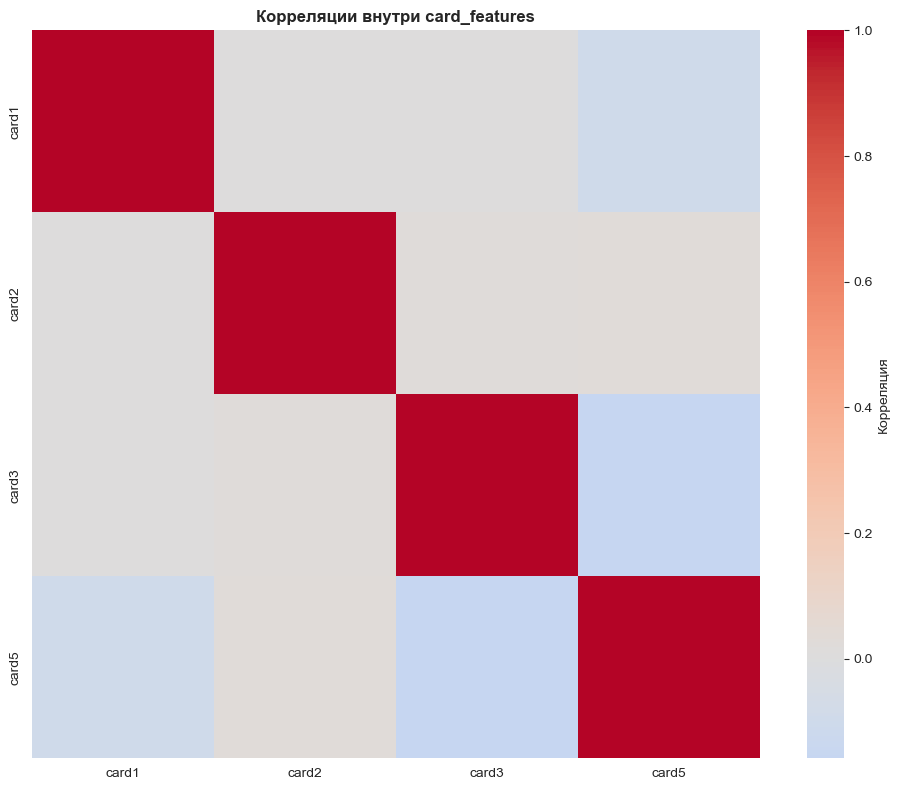


Высоко коррелированные пары (|r| > 0.9):
Нет пар выше порога


In [38]:
plot_corr_and_pairs(train, card_features, title='Корреляции внутри card_features', threshold=0.9);

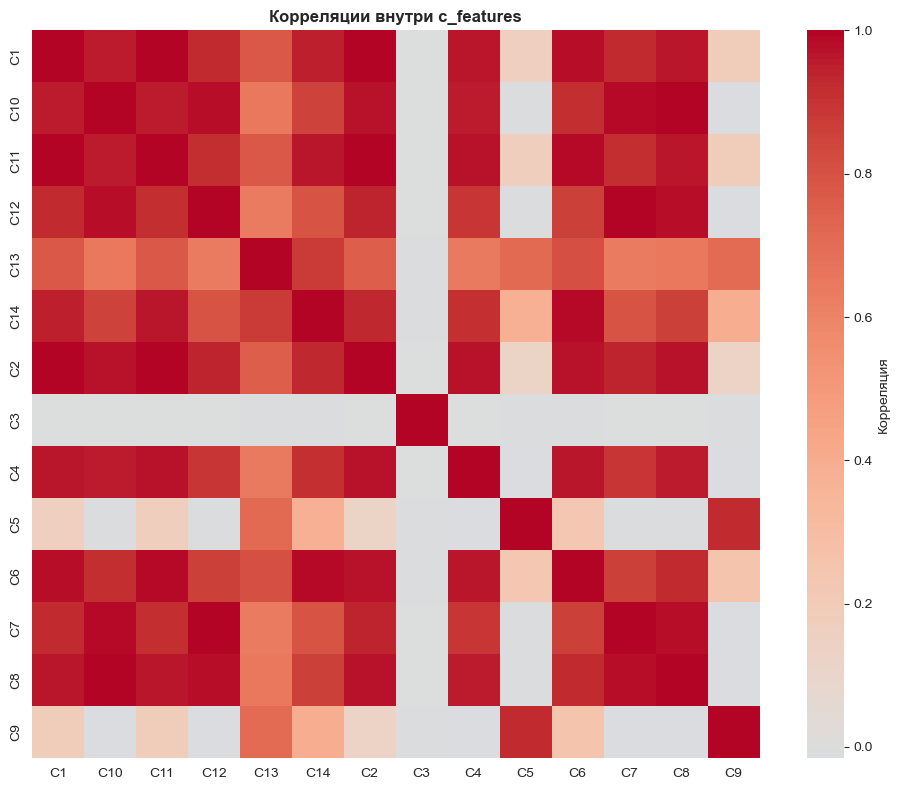


Высоко коррелированные пары (|r| > 0.9):
C12 <-> C7: 0.9995
C10 <-> C8: 0.9970
C1 <-> C11: 0.9965
C1 <-> C2: 0.9951
C11 <-> C2: 0.9939
C11 <-> C6: 0.9911
C10 <-> C7: 0.9851
C14 <-> C6: 0.9842
C10 <-> C12: 0.9838
C12 <-> C8: 0.9830


In [39]:
plot_corr_and_pairs(train, c_features,    title='Корреляции внутри c_features',    threshold=0.9);

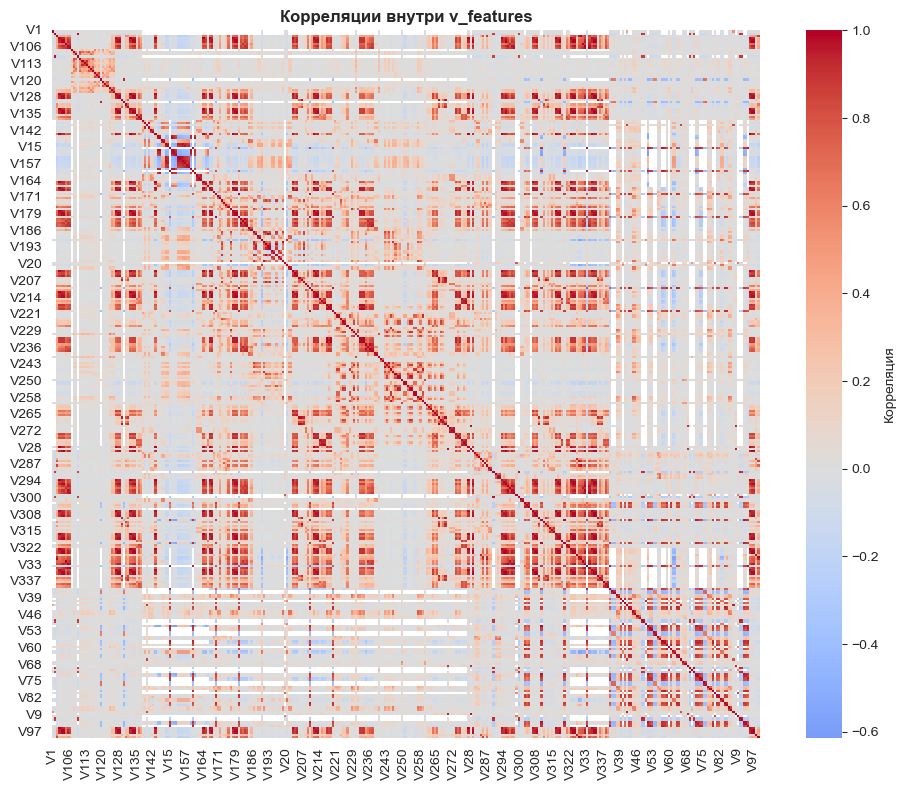


Высоко коррелированные пары (|r| > 0.9):
V322 <-> V95: 0.9999
V323 <-> V96: 0.9999
V324 <-> V97: 0.9999
V101 <-> V322: 0.9997
V279 <-> V322: 0.9996
V101 <-> V95: 0.9996
V279 <-> V293: 0.9996
V280 <-> V324: 0.9995
V293 <-> V322: 0.9994
V167 <-> V177: 0.9994


In [40]:
plot_corr_and_pairs(train, v_features,    title='Корреляции внутри v_features',    threshold=0.9);

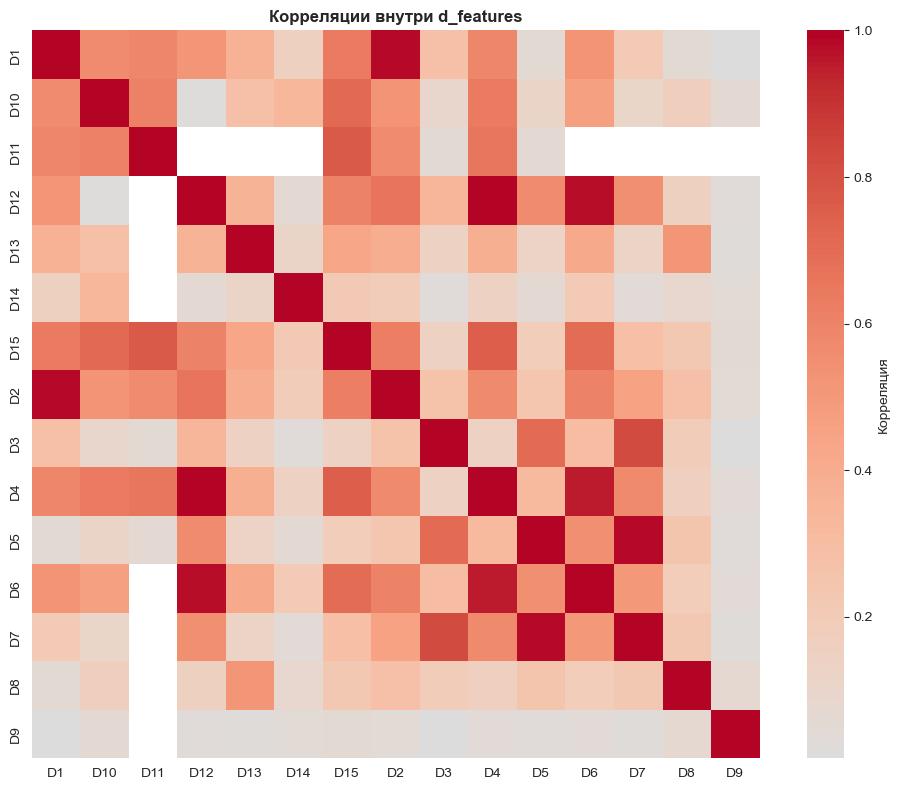


Высоко коррелированные пары (|r| > 0.9):
D12 <-> D4: 1.0000
D5 <-> D7: 0.9865
D1 <-> D2: 0.9813
D12 <-> D6: 0.9768
D4 <-> D6: 0.9570


In [41]:
plot_corr_and_pairs(train, d_features,    title='Корреляции внутри d_features',    threshold=0.9);

#### Выводы по корреляциям

#### card_features: 
- корреляции в целом умеренные/низкие, выраженных кластеров дублей нет → группа выглядит относительно независимой, обычно без приоритетного дропа.​

#### c_features: 
- встречаются сильно коррелированные связки (потенциальные дубли/почти линейные зависимости) → кандидаты на отбор/дроп по порогу ∣r∣>0.9∣r∣>0.9 или регуляризацию. ​

#### v_features: 
- характерна “блоковая” структура корреляций (подгруппы признаков с высокой внутригрупповой связностью) → стоит рассмотреть агрегацию/снижение размерности (например, PCA/SVD по блокам) либо отбор внутри блоков.​

#### d_features: 
- “блоковость” + явные пары с ∣r∣>0.9∣r∣>0.9 (например, D12–D4≈1.000, D1–D2≈0.981, D5–D7≈0.987) → прямые кандидаты на удаление одного из пары/кластера. ​

#### Общая рекомендация: контроль мультиколлинеарности фокусировать на c/v/d, а card_features оставлять как базовую, менее избыточную группу.

## 6. Взаимосвязь с таргетом

In [42]:
target_col = 'isFraud'

print('Статистика таргета (isFraud):')
print(f'\nКласс 0 (нормально): {(train[target_col] == 0).sum()} ({(train[target_col] == 0).sum() / len(train) * 100:.2f}%)')
print(f'Класс 1 (мошенничество): {(train[target_col] == 1).sum()} ({(train[target_col] == 1).sum() / len(train) * 100:.2f}%)')
print(f'\nДисбаланс классов: {(train[target_col] == 0).sum() / (train[target_col] == 1).sum():.1f}:1')

Статистика таргета (isFraud):

Класс 0 (нормально): 569877 (96.50%)
Класс 1 (мошенничество): 20663 (3.50%)

Дисбаланс классов: 27.6:1


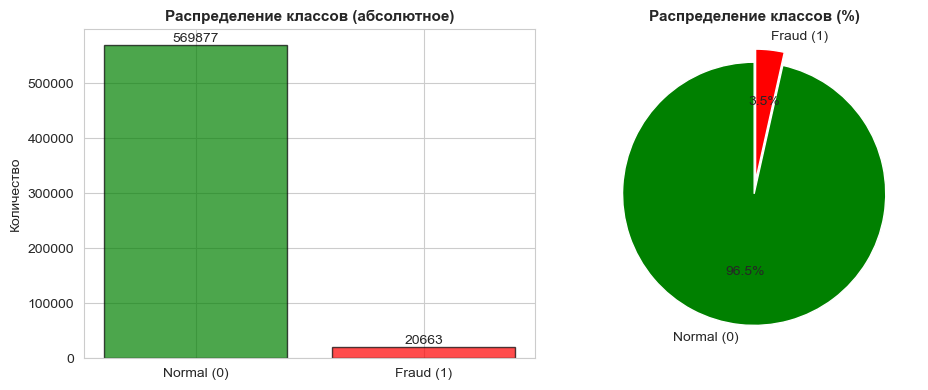

In [43]:
# Визуализация баланса классов
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

class_counts = train[target_col].value_counts()
axes[0].bar(['Normal (0)', 'Fraud (1)'], class_counts.values, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Количество')
axes[0].set_title('Распределение классов (абсолютное)', fontsize=11, fontweight='bold')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

class_pct = train[target_col].value_counts(normalize=True) * 100
axes[1].pie(class_pct.values, labels=['Normal (0)', 'Fraud (1)'], autopct='%1.1f%%', 
            colors=['green', 'red'], startangle=90, explode=(0, 0.1))
axes[1].set_title('Распределение классов (%)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

**Важно**: Сильный дисбаланс классов! Нужны TimeSeriesSplit CV, AUC, precision-recall метрики.

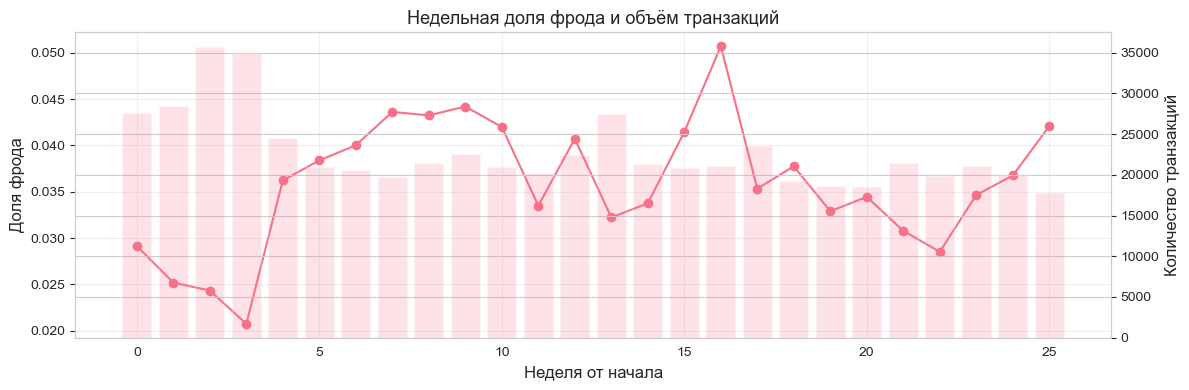

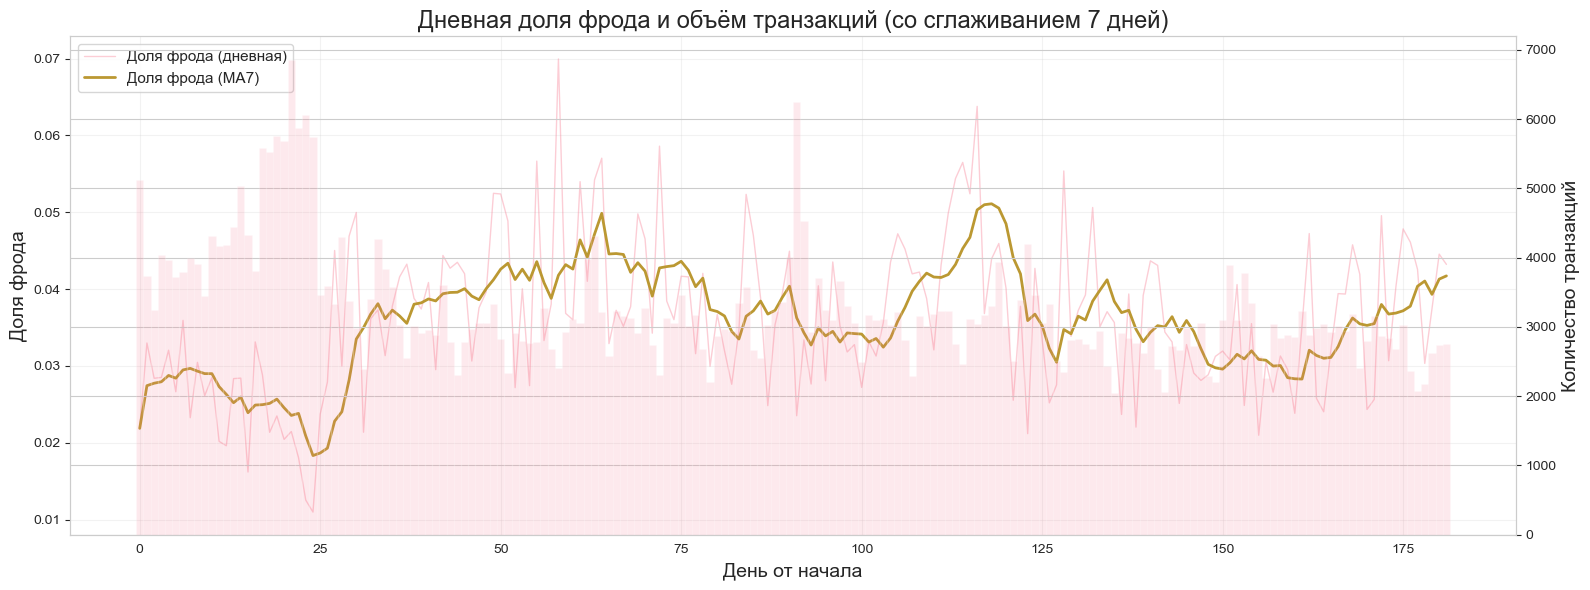

In [65]:
weekly = weekly_fraud_analysis(train)
weekly.head()
plot_weekly_fraud(weekly)

daily = daily_fraud_analysis(train)
daily.head()
plot_daily_fraud(daily)

## 📈 Анализ временных паттернов

### Зачем два графика (дневной и недельный)

Дневной и недельный графики вместе дают "лупу + карту": дневной показывает краткосрочные всплески/аномалии, а недельный (или MA7) — устойчивый тренд и возможный дрейф во времени. Поскольку TransactionDT покрывает примерно 182 дня, переход к неделям помогает убрать шум и увидеть структуру на горизонте месяцев.

---

### Что дают графики

**Дневной график**: видно, что fraud rate заметно "шумит" от дня к дню, а столбцы по числу транзакций помогают понять, где скачки могут быть просто эффектом меньшего объёма.

**MA7 (7-дневное сглаживание)** на дневном графике — компромисс: оставляет динамику "неделя-к-неделе", но не теряет локальные изменения внутри месяца.

**Недельный график** даёт более стабильную картину (меньше точек, больше наблюдений в бине), поэтому лучше подходит для вывода про общий тренд/сезонность на всем периоде.

---

### Ключевые наблюдения по времени

Дневной fraud rate колеблется сильнее недельного, поэтому одиночные пики/провалы на уровне дней стоит интерпретировать через объём (если в конкретный день транзакций меньше, доля fraud "скачет" сильнее).

MA7 и недельная агрегация позволяют отделить шум от устойчивых волн: если "волна" видна и на MA7, и на недельном — это уже не случайные флуктуации.

На таком горизонте (≈182 дня) временные эффекты легко маскируют/усиливают другие зависимости (например, по сумме), поэтому сравнение day/week полезно как проверка стабильности паттернов.

---

### Выводы (что это значит)

Во времени есть сигнал: fraud rate не выглядит константой, а меняется по периодам, значит возможен concept drift (меняется "мошенническое поведение" или смесь типов транзакций).

Недельный график нужен для стратегических выводов (долгий тренд), дневной — для диагностики "инцидентов" (всплеск, атака, сбой правил), и вместе они помогают не принять шум за тренд и наоборот.

---

### Практические рекомендации

**Для модели**: добавить dt_day, dt_week (или dt_day // 7) и аккуратные rolling-фичи "только в прошлое" (например, 7/14/28-дневные агрегаты по card*, addr*, ProductCD), чтобы поймать динамику без утечки таргета.

**Для валидации**: использовать time-based split (или хотя бы разбиение по времени), потому что случайный K-fold может переоценить качество, если в данных есть временной дрейф.


In [66]:
# Средняя сумма по классам
fraud_stats = train.groupby(target_col)['TransactionAmt'].agg(['mean', 'median', 'std', 'min', 'max'])
print('\nСтатистика TransactionAmt по классам:')
fraud_stats


Статистика TransactionAmt по классам:


,mean,median,std,min,max
isFraud,,,,,
0,134.511665,68.5,239.395078,0.251,31937.391
1,149.244779,75.0,232.212163,0.292,5191.000


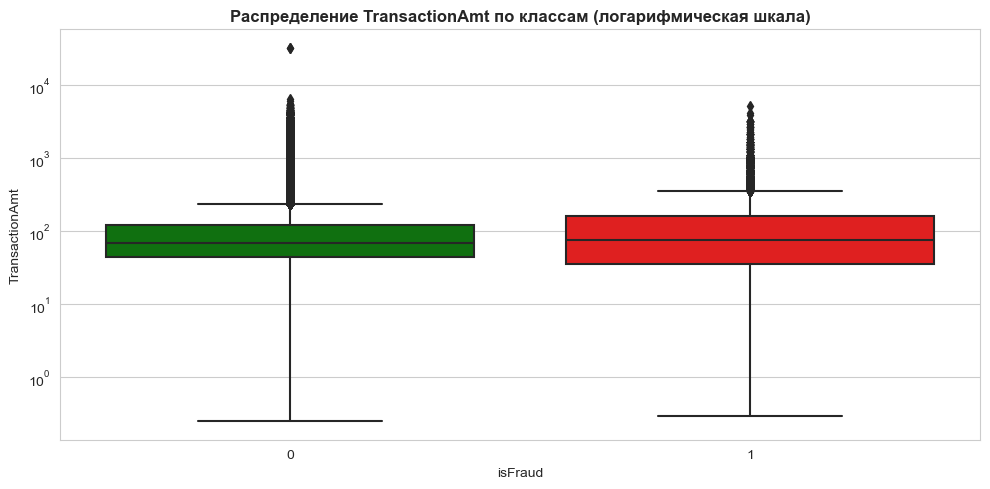

In [67]:
# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x=target_col, y='TransactionAmt', palette=['green', 'red'])
plt.yscale('log')
plt.title('Распределение TransactionAmt по классам (логарифмическая шкала)', fontsize=12, fontweight='bold')
plt.ylabel('TransactionAmt')
plt.xlabel('isFraud')
plt.tight_layout()
plt.show()

### КОРРЕЛЯЦИИ с isFraud

In [70]:
try:
    from IPython.display import display
except Exception:
    display = None

res = run_fraud_feature_report(train);
res["mi"].head(30)
res["nonlinear"].head(10)

Rows: 590,540 | Fraud rate: 3.50% | Sample: 100,000

Top correlations (abs > 0.01)
-----------------------------


,pearson_abs,spearman_abs
V257,0.383060,0.387434
V246,0.366878,0.398693
V244,0.364129,0.404460
V242,0.360590,0.395531
V201,0.328005,0.282981
V200,0.318783,0.271738
V189,0.308219,0.256804
V188,0.303582,0.240248
V258,0.297151,0.385553
V45,0.281832,0.184659



Mutual Info top-30 (sample stratified, top-200 corr + missing flags)
--------------------------------------------------------------------


,feature,mi
0,V258,0.032293
1,V246,0.029467
2,V201,0.027062
3,V259,0.026269
4,V199,0.025884
5,V257,0.025477
6,V189,0.025311
7,V243,0.024944
8,V190,0.024513
9,V200,0.024278



D-features: mean/median diff + missing_rate
-------------------------------------------


,feature,mean_0,mean_1,med_0,med_1,missing_rate,abs_mean_diff,abs_med_diff
0,D2,171.956223,77.774206,100.000000,16.000000,0.475492,94.182017,84.000000
1,D15,166.633142,78.245805,56.000000,1.000000,0.150901,88.387337,55.000000
2,D8,157.343727,49.309191,50.583332,2.666666,0.873123,108.034536,47.916666
3,D11,147.808201,87.314445,44.000000,7.000000,0.472935,60.493756,37.000000
4,D4,142.432339,72.102904,28.000000,1.000000,0.286047,70.329435,27.000000
5,D10,126.396130,52.363653,18.000000,0.000000,0.128733,74.032477,18.000000
6,D5,43.491155,13.687776,10.000000,0.000000,0.524674,29.803379,10.000000
7,D3,28.845357,11.744880,8.000000,1.000000,0.445149,17.100477,7.000000
8,D1,96.364705,38.711306,4.000000,0.000000,0.002149,57.653399,4.000000
9,D9,0.565846,0.520000,0.666666,0.625000,0.873123,0.045847,0.041666



Nonlinearity check: fraud_rate range across quantile bins (top MI feats)
------------------------------------------------------------------------


,feature,fraud_rate_range,min_bin_n,total_n
5,V257,0.618428,5009,130430
0,V258,0.571960,6224,130430
4,V199,0.526394,5104,139631
6,V189,0.466555,7077,139819
7,V243,0.381326,10179,130430
1,V246,0.374666,11048,130430
8,V190,0.350155,10768,139631
9,V200,0.329430,12376,139819
2,V201,0.316056,13828,139819
3,V259,0.284786,11602,141416


,feature,fraud_rate_range,min_bin_n,total_n
5,V257,0.618428,5009,130430
0,V258,0.571960,6224,130430
4,V199,0.526394,5104,139631
6,V189,0.466555,7077,139819
7,V243,0.381326,10179,130430
1,V246,0.374666,11048,130430
8,V190,0.350155,10768,139631
9,V200,0.329430,12376,139819
2,V201,0.316056,13828,139819
3,V259,0.284786,11602,141416


## 📊 Интерпретация результатов корреляционного анализа

### Ключевые выводы

Это означает три вещи: 
1. **V-фичи** реально "сильные" уже в одиночку
2. У **D-фичей** (и даже у "missing" от D7) есть сильный сигнал
3. По **fraud_rate_range** видно, что связь у части V-фичей нелинейная (по бинам риск меняется заметно)

---

### 1) Top correlations — что это

**pearson_abs** — сила линейной связи фичи с isFraud.

**spearman_abs** — сила монотонной связи (через ранги), лучше ловит нелинейные "ступеньки/пороги", даже если связь не линейная.

У тебя топ почти весь из V*** и значения 0.2–0.4 — это очень много для fraud-датасета и уже намекает, что в V-группе лежат агрегаты/конструированные признаки, сильно разделяющие классы.

**Как читать**: если у фичи Spearman заметно больше Pearson (например V243: 0.210 vs 0.389), значит зависимость "монотонная, но нелинейная" — модель типа логрега без бинирования может недобрать, а деревья/GBDT обычно забирают.

---

### 2) Mutual Info — что значит величина mi

**mutual_info_classif** оценивает нелинейную зависимость признака и таргета: MI = 0 ⇔ независимы, чем больше — тем больше зависимости.

Абсолютная шкала MI "не в процентах"; сравнивать корректно внутри одного запуска (между фичами).

То, что в топе есть miss_D7 (≈0.021) — означает: "факт пропуска D7" (NaN/не-NaN) сам по себе информативен про fraud, и это типичный паттерн для этого датасета (D-фичи очень дырявые).

**Почему MI топ-значения небольшие (0.02–0.03), но это нормально**: таргет редкий (≈3.5%), а MI — оценка энтропийной зависимости на kNN-оценивании, она часто получается "малой" по числу, даже когда признак полезен.

---

### 3) D-features diff — что значит таблица

У тебя, например, D2: median у non-fraud ≈ 100, у fraud ≈ 16 (разница 84), и missing_rate ≈ 0.48 — это сильный сдвиг распределения между классами, не просто шум.

**Важно**: большие missing_rate (D7/D8/D9…) подсказывают, что надо обязательно держать missing-флаг и аккуратно обрабатывать NaN, иначе модель теряет сигнал.

---

### 4) "Nonlinearity check" — как интерпретировать fraud_rate_range

Ты делал так: разбил фичу на квантили (примерно равные по размеру бины) и посмотрел fraud rate в каждом бине, а потом посчитал:

**fraud_rate_range = max(fraud_rate по бинам) − min(fraud_rate по бинам)**

Например, V257 fraud_rate_range = 0.618 означает: между "самым безопасным" и "самым рискованным" квантилем этой фичи доля fraud различается примерно на 0.62 процентных пункта (т.е. ~3.1% vs ~3.7%, если базовый ~3.5%).

Это и есть признак нелинейности/порогов: зависимость не обязана быть прямой линией, она может быть ступенчатой.

**min_bin_n** показывает, что в каждом бине у тебя тысячи наблюдений (5k–13k), то есть это не "шум из-за маленьких групп".

---

## 🎯 Практический вывод

Фичи с большим fraud_rate_range особенно хорошо раскрываются в GBDT/LightGBM/CatBoost или при бинировании (qcut/WOE) перед линейной моделью.


### ИТОГОВАЯ СВОДКА ПО ГРУППАМ:

ИТОГОВАЯ СВОДКА ПО ГРУППАМ:
             Group  Count  Missing_%  Affected
7     id__features     38      84.82        38
1       D_features     15      58.15        15
2       M_features      9      49.92         9
8   other_features      9      44.68         6
3       V_features    339      43.04       339
4    addr_features      2      11.13         2
6    card_features      6       0.51         5
0       C_features     14       0.00         0
5    base_features      3       0.00         0
9  target_features      1       0.00         0




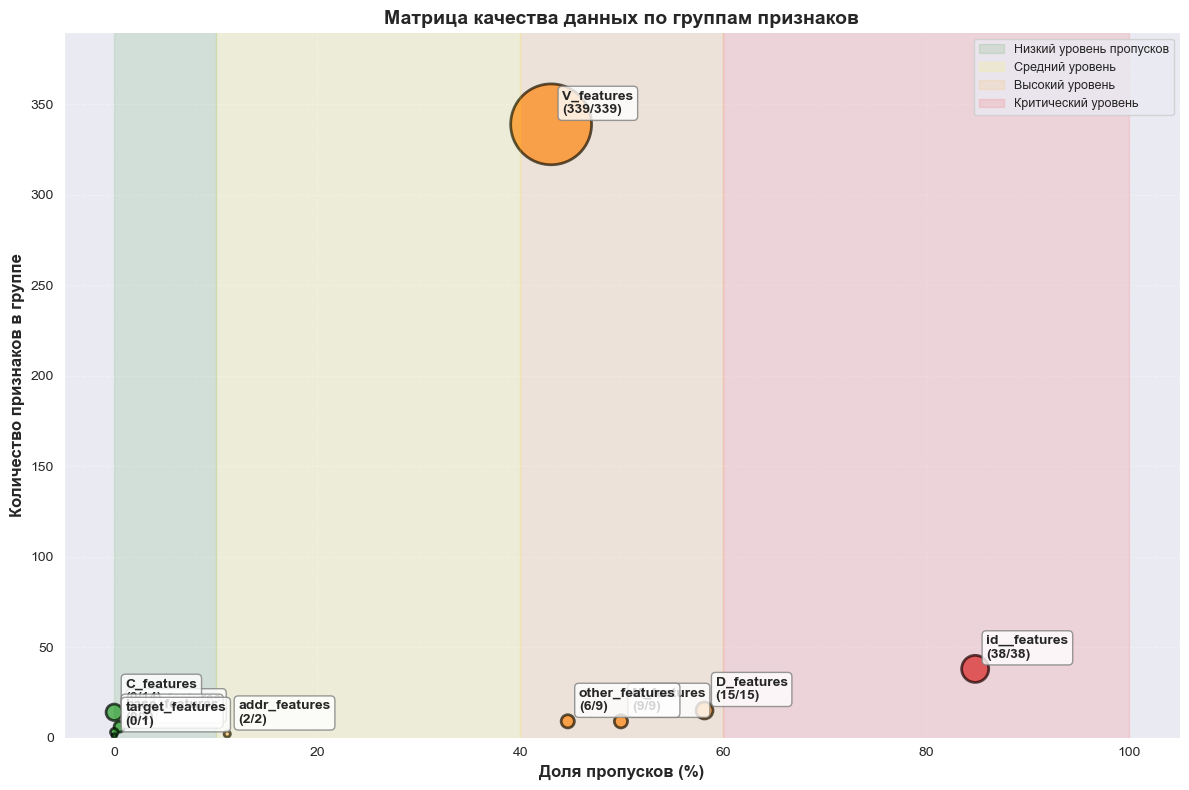


ПРИОРИТИЗАЦИЯ ГРУПП ДЛЯ ОБРАБОТКИ

id__features:
  Приоритет: 🔴 КРИТИЧНО
  Пропуски: 84.82% (38/38 признаков затронуты)
  Действие: Рассмотреть дроп или специальную обработку

D_features:
  Приоритет: 🟠 ВЫСОКИЙ
  Пропуски: 58.15% (15/15 признаков затронуты)
  Действие: Создать is_missing флаги + заполнение

M_features:
  Приоритет: 🟠 ВЫСОКИЙ
  Пропуски: 49.92% (9/9 признаков затронуты)
  Действие: Создать is_missing флаги + заполнение

other_features:
  Приоритет: 🟠 ВЫСОКИЙ
  Пропуски: 44.68% (6/9 признаков затронуты)
  Действие: Создать is_missing флаги + заполнение

V_features:
  Приоритет: 🟠 ВЫСОКИЙ
  Пропуски: 43.04% (339/339 признаков затронуты)
  Действие: Создать is_missing флаги + заполнение

addr_features:
  Приоритет: 🟡 СРЕДНИЙ
  Пропуски: 11.13% (2/2 признаков затронуты)
  Действие: Простое заполнение (median/mode)

card_features:
  Приоритет: 🟢 НИЗКИЙ
  Пропуски: 0.51% (5/6 признаков затронуты)
  Действие: Минимальная обработка

C_features:
  Приоритет: 🟢 НИЗКИЙ
  Пропуски

In [72]:
summary_df = analyze_missing_by_groups(train, feature_groups)

## 7. Финальные выводы и план обработки

#### ✅ Сильно предиктивные признаки
1. **V-features**: V257, V246, V244, V242, V201 — высокие корреляции >0.3
2. **D-features**: D2, D15, D8 — большие различия fraud/non-fraud (Δ>70)
3. **DeviceInfo**: критически важен (fraud lift=27.08)
4. **C-features**: полностью заполнены (0% пропусков) — стабильны
5. **Missing flags**: miss_D7 имеет MI=0.0214 — сам пропуск информативен

#### ⚠️ Проблемы данных
1. **Критические пропуски**:
   - id_features: 84.8% (identity данные часто отсутствуют)
   - DeviceInfo: 79.9% (но критически важен!)
   - dist2: 93.6%
   - D-features: 58.2% (временные дельты)
2. **Дисбаланс классов**: 3.5% fraud → нужны техники балансировки
3. **Анонимизация**: V-features проприетарны → сложно интерпретировать

#### 🔧 Рекомендации для моделирования

**1. Feature Engineering**:
- ✅ Временные признаки: `hour_of_day`, `day_of_week`, `is_night`, `is_weekend`
- ✅ Агрегации TransactionAmt: log, sqrt, бины (квантили, категории)
- ✅ **Missing flags** для D, V-features (miss_D7, miss_V*, etc.) — сами пропуски информативны!
- ✅ Device parsing: извлечь OS, browser, type, vendor из DeviceInfo
- ✅ Уникальные идентификаторы: `UID = f(card1, addr1, D1)`, `card1_addr1`

**2. Feature Selection**:
- ❌ Удалить высококоррелированные V-features (корреляция >0.75 между собой)
- ❌ Сократить C-features до топ-5: C13, C10, C11, C4, C7
- ❌ Удалить ID-признаки с >99% пропусков (id_24, id_25, id_07, etc.)

**3. Обработка пропусков**:
- ✅ **CatBoost** с `nan_mode='Min'` — автоматическая обработка NaN (лучший вариант!)
- ✅ Для других моделей: median imputation (числовые признаки)
- ✅ Missing flags: создать бинарные признаки `miss_*` для признаков с >10% пропусков

**4. Балансировка классов**:
- ✅ `scale_pos_weight` в CatBoost/LightGBM: ~**27.58** (соотношение non-fraud/fraud)
- ✅ Метрика: **ROC-AUC** (устойчива к дисбалансу классов, официальная метрика соревнования)

---

**Результат EDA**: глубокое понимание данных для эффективного feature engineering и моделирования 🚀